# SWB Regression Pipeline - HFA Power 
Created: 09/30/2024 \
Updated: 10/01/2024 \
*ran with 1 sec regression dfs from 09/25/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



10012024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


# Load beta power data 

In [6]:
epoch_len = '1sec'

In [7]:
band = 'hfa' 
hfa_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
hfa_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [10]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [11]:
# ####### NEW DATA FRAME 
hfa_reg_df = hfa_df.copy()
hfa_reg_df = hfa_reg_df[hfa_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [12]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
# reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+Profit+cpe'

n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(hfa_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2771.22it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2795.95it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2886.01it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2788.68it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2800.01it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2783.50it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2767.20it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2761.79it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2769.16it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2803.27it/s]


In [13]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'Profit', 'cpe']

In [14]:
results = single_elec_permutation_results(results_dict,hfa_reg_df,save_vars)
results

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.031481   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.031584   
2     MS002_lacas3-lacas4   MS002    acc   14                    -0.006661   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.012905   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.031800   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                    -0.030028   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.010377   
1185  DA039_rpins3-rpins4   DA039   pins   22                     0.023413   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.030218   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.034198   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.035772                  -0.029481   
1                                  -0.047934                  -0.032385   
2                                  -0.002486                  -0.015895   
3                                  -0.017408                  -0.012853   
4                                  -0.027026                  -0.070554   
...                                      ...                        ...   
1183                                0.001550                   0.049720   
1184                               -0.018097                   0.026313   
1185                               -0.032101                   0.024768   
1186                                0.027728                  -0.013354   
1187                                0.026366                  -0.013252   

      Original_Estimate_Profit  Original_Estimate_cpe  \
0                     0.082813              -0.004988   
1                     0.038938               0.002566   
2                    -0.003642              -0.013389   
3                    -0.009086              -0.022870   
4                     0.074491              -0.036509   
...                        ...                    ...   
1183                 -0.042741              -0.000795   
1184                  0.029712              -0.054147   
1185                  0.027561              -0.057190   
1186                  0.008183               0.022229   
1187                  0.018033              -0.008852   

      Permuted_Mean_Intercept  ...  Z_Score_Intercept  \
0                    0.006794  ...           1.634520   
1                   -0.001269  ...           2.112212   
2                   -0.008057  ...           0.109010   
3                    0.000319  ...           0.857184   
4                    0.013566  ...           1.208351   
...                       ...  ...                ...   
1183                -0.027255  ...          -0.263858   
1184                 0.004607  ...           0.441403   
1185                 0.011301  ...           0.743196   
1186                -0.019469  ...          -1.407904   
1187                -0.024724  ...          -1.294987   

      Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  Z_Score_Profit  \
0                        -1.642721        -1.014304        2.588456   
1                        -2.111802        -1.110132        1.264629   
2                        -0.109500        -0.609198       -0.091299   
3                        -0.861566        -0.478357       -0.227621   
4                        -1.215717        -2.365300        2.464328   
...                            ...              ...             ...   
1183                      0.089592         1.391681       -0.938578   
1184                     -0.573195         0.611656        0.528312   
1185                     -0.869529         0.409252        0.464395   
1186                      1.549441        -0.516820        0.254140   
1187                  

### Save results as pickle file

In [15]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_combomodel-Profit_cpe_regression_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

# CPE Results

In [16]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
12      MS002_laims1-laims2   MS002   ains   14                     0.034774   
38      MS002_lpips1-lpips2   MS002   pins   14                    -0.027223   
58      MS002_raims1-raims2   MS002   ains   14                     0.017279   
64    MS002_raims12-raims13   MS002  dlpfc   14                    -0.028620   
71      MS002_rmoif3-rmoif4   MS002    ofc   14                     0.016302   
...                     ...     ...    ...  ...                          ...   
1104    MS050_rmoif7-rmoif8   MS050    ofc    9                     0.117977   
1105    MS050_rmoif8-rmoif9   MS050  vlpfc    9                     0.083236   
1136        DA026_lhh1-lhh2   DA026    hpc   19                    -0.029553   
1138        DA026_lhh3-lhh4   DA026    hpc   19                     0.003081   
1168        DA039_rfp3-rfp4   DA039    ofc   22                    -0.029877   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
12                                 -0.027565                  -0.094876   
38                                 -0.024934                   0.021820   
58                                 -0.013387                  -0.062180   
64                                 -0.005182                  -0.006274   
71                                 -0.015556                  -0.076927   
...                                      ...                        ...   
1104                                0.100766                   0.075627   
1105                                0.036746                  -0.013686   
1136                               -0.007144                   0.018354   
1138                               -0.001238                  -0.000095   
1168                               -0.003286                  -0.019056   

      Original_Estimate_Profit  Original_Estimate_cpe  \
12                    0.126246              -0.064235   
38                   -0.082696               0.052965   
58                    0.046536              -0.048291   
64                    0.052234              -0.062198   
71                    0.061092              -0.060743   
...                        ...                    ...   
1104                 -0.120288               0.148765   
1105                 -0.034787               0.125848   
1136                 -0.039797               0.055425   
1138                  0.012111              -0.042743   
1168                  0.036904              -0.020081   

      Permuted_Mean_Intercept  ...  Z_Score_Intercept  \
12                   0.015850  ...           1.313240   
38                  -0.044722  ...           1.247704   
58                   0.007746  ...           0.725332   
64                  -0.031857  ...           0.206824   
71                   0.005704  ...           0.548297   
...                       ...  ...                ...   
1104                 0.168122  ...          -2.763940   
1105                 0.100891  ...          -1.055052   
1136                -0.032710  ...           0.286261   
1138                 0.002831  ...           0.027085   
1168                -0.031799  ...           0.646475   

      Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  Z_Score_Profit  \
12                       -1.332959        -3.216302        3.932787   
38                       -1.223142         0.774300       -2.809871   
58                       -0.735005        -2.324878        1.654191   
64                       -0.231947        -0.213735        1.545546   
71                       -0.556852        -2.078273        1.538486   
...                            ...              ...             ...   
1104                      2.808045         1.410559       -1.892243   
1105                      1.115917        -0.249534       -0.609603   
1136                     -0.305344         0.566568       -1.262669   
1138                     -0.032681         0.023509        0.455971   


In [17]:
sig_data.roi.value_counts()



roi
ofc      13
dmpfc    10
acc      10
ains      9
dlpfc     8
amy       8
pins      7
hpc       7
vlpfc     5
Name: count, dtype: int64

In [18]:
sig_data.roi.unique()



array(['ains', 'pins', 'dlpfc', 'ofc', 'acc', 'vlpfc', 'dmpfc', 'amy',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [19]:
# add mask col for sig cpe elecs 
results['cpe_sig']   = results['P_Value_cpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.031481   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.031584   
2  MS002_lacas3-lacas4   MS002  acc   14                    -0.006661   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.012905   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.031800   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.035772                  -0.029481   
1                               -0.047934                  -0.032385   
2                               -0.002486                  -0.015895   
3                               -0.017408                  -0.012853   
4                               -0.027026                  -0.070554   

   Original_Estimate_Profit  Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.082813              -0.004988                 0.006794   
1                  0.038938               0.002566                -0.001269   
2                 -0.003642              -0.013389                -0.008057   
3                 -0.009086              -0.022870                 0.000319   
4                  0.074491              -0.036509                 0.013566   

   ...  Z_Score_TrialEV  Z_Score_Profit  Z_Score_cpe  P_Value_Intercept  \
0  ...        -1.014304        2.588456    -0.228201           0.102150   
1  ...        -1.110132        1.264629     0.066425           0.034668   
2  ...        -0.609198       -0.091299    -0.685208           0.913194   
3  ...        -0.478357       -0.227621    -1.008087           0.391343   
4  ...        -2.365300        2.464328    -1.574568           0.226912   

   P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_Profit  P_Value_cpe  \
0                      0.100441         0.310438        0.009641     0.819490   
1                      0.034703         0.266942        0.206004     0.947039   
2                      0.912806         0.542393        0.927255     0.493212   
3                      0.388926         0.632396        0.819941     0.313413   
4                      0.224093         0.018015        0.013727     0.115356   

   cpe_sig  bdi_split  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0  

[5 rows x 31 columns]

In [20]:
cpe_var = 'Z_Score_cpe'

In [21]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [22]:
results.groupby('roi').agg('mean',numeric_only=True)[cpe_var][bar_order]



roi
dlpfc   -0.076267
vlpfc    0.316835
dmpfc    0.174286
ofc      0.134987
ains     0.328388
pins    -0.060674
acc      0.113185
amy      0.092625
hpc     -0.115856
Name: Z_Score_cpe, dtype: float64

In [23]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[cpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.cpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].cpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [24]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     10  0.051813              1    1.497941    0.135791   
1  dmpfc      225     10  0.044444              2    2.604949    0.009804   
2    amy      113      8  0.070796              2    0.893229    0.373650   
3   ains       71      9  0.126761              1    2.249090    0.027655   
4  vlpfc       82      5  0.060976              2    3.124482    0.002472   
5    hpc      135      7  0.051852              0   -1.361709    0.175575   
6    ofc      202     13  0.064356              5    1.757809    0.080302   
7   pins       60      7  0.116667              4   -0.385740    0.701076   
8  dlpfc      107      8  0.074766              1   -0.744770    0.458059   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.028377            1.0    0.051813      0.4997  
1      0.024308            1.0    0.044444      0.6920  
2      0.035713            1.0    0.070796      0.2049  
3      0.067750            1.0    0.126761      0.0088  
4      0.024331            1.0    0.060976      0.3912  
5      0.024586            1.0    0.051852      0.5154  
6      0.038484            1.0    0.064356      0.2132  
7      0.056055            1.0    0.116667      0.0297  
8      0.037745            1.0    0.074766      0.1673

In [25]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
3  ains       71      9  0.126761              1     2.24909    0.027655   
7  pins       60      7  0.116667              4    -0.38574    0.701076   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
3      0.067750            1.0    0.126761      0.0088  
7      0.056055            1.0    0.116667      0.0297

In [26]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodel-Profit-cpe_coeff_barplot_{epoch_len}.pdf'


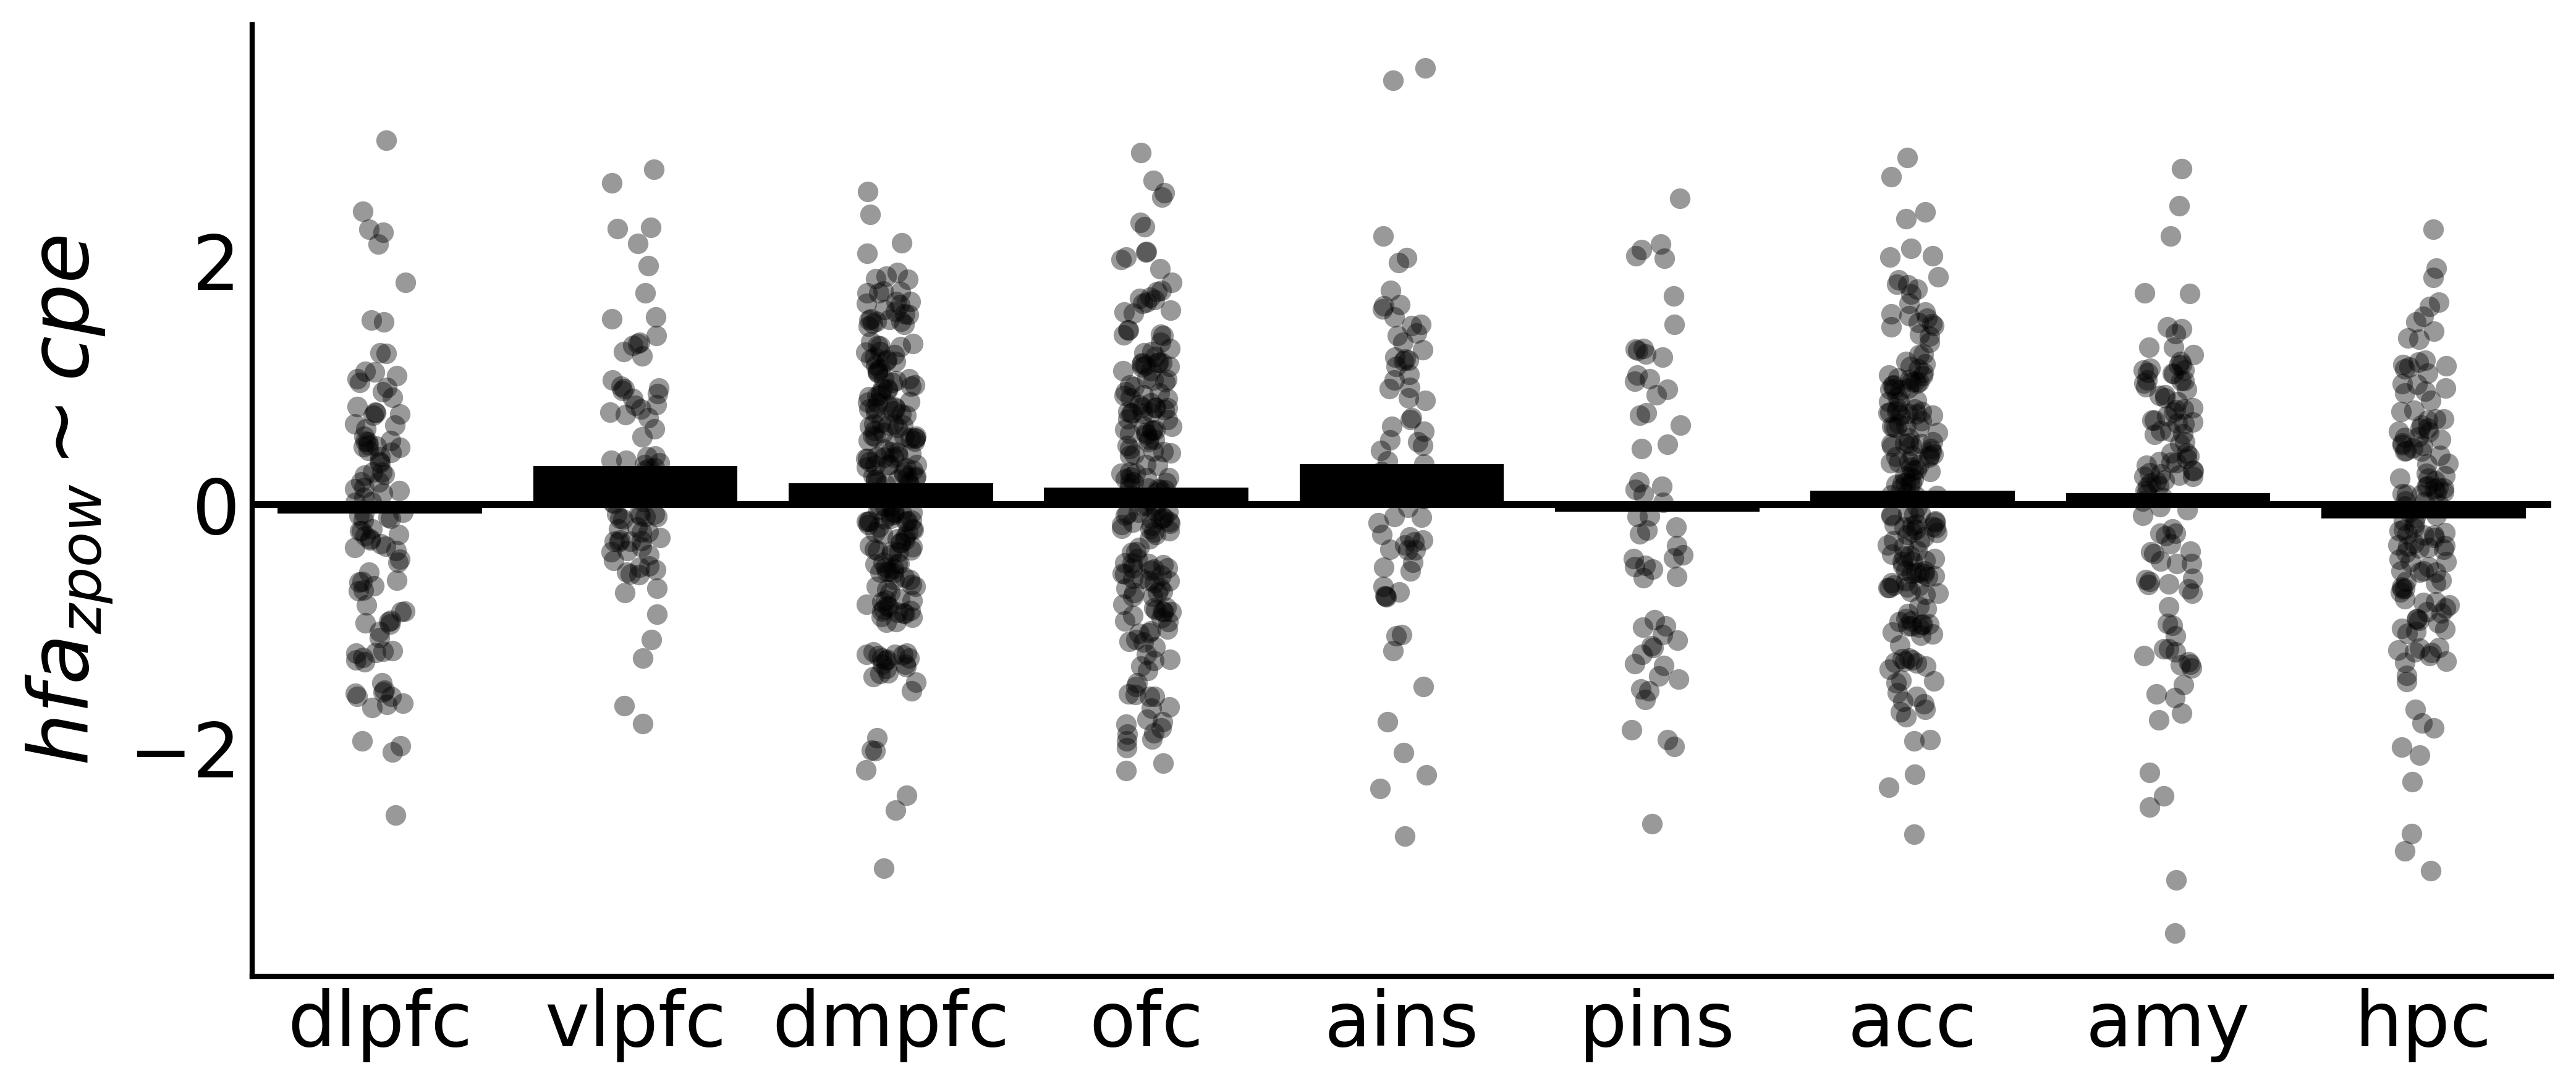

In [27]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim cpe$'


plot_roi_model_results(results,'roi',cpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

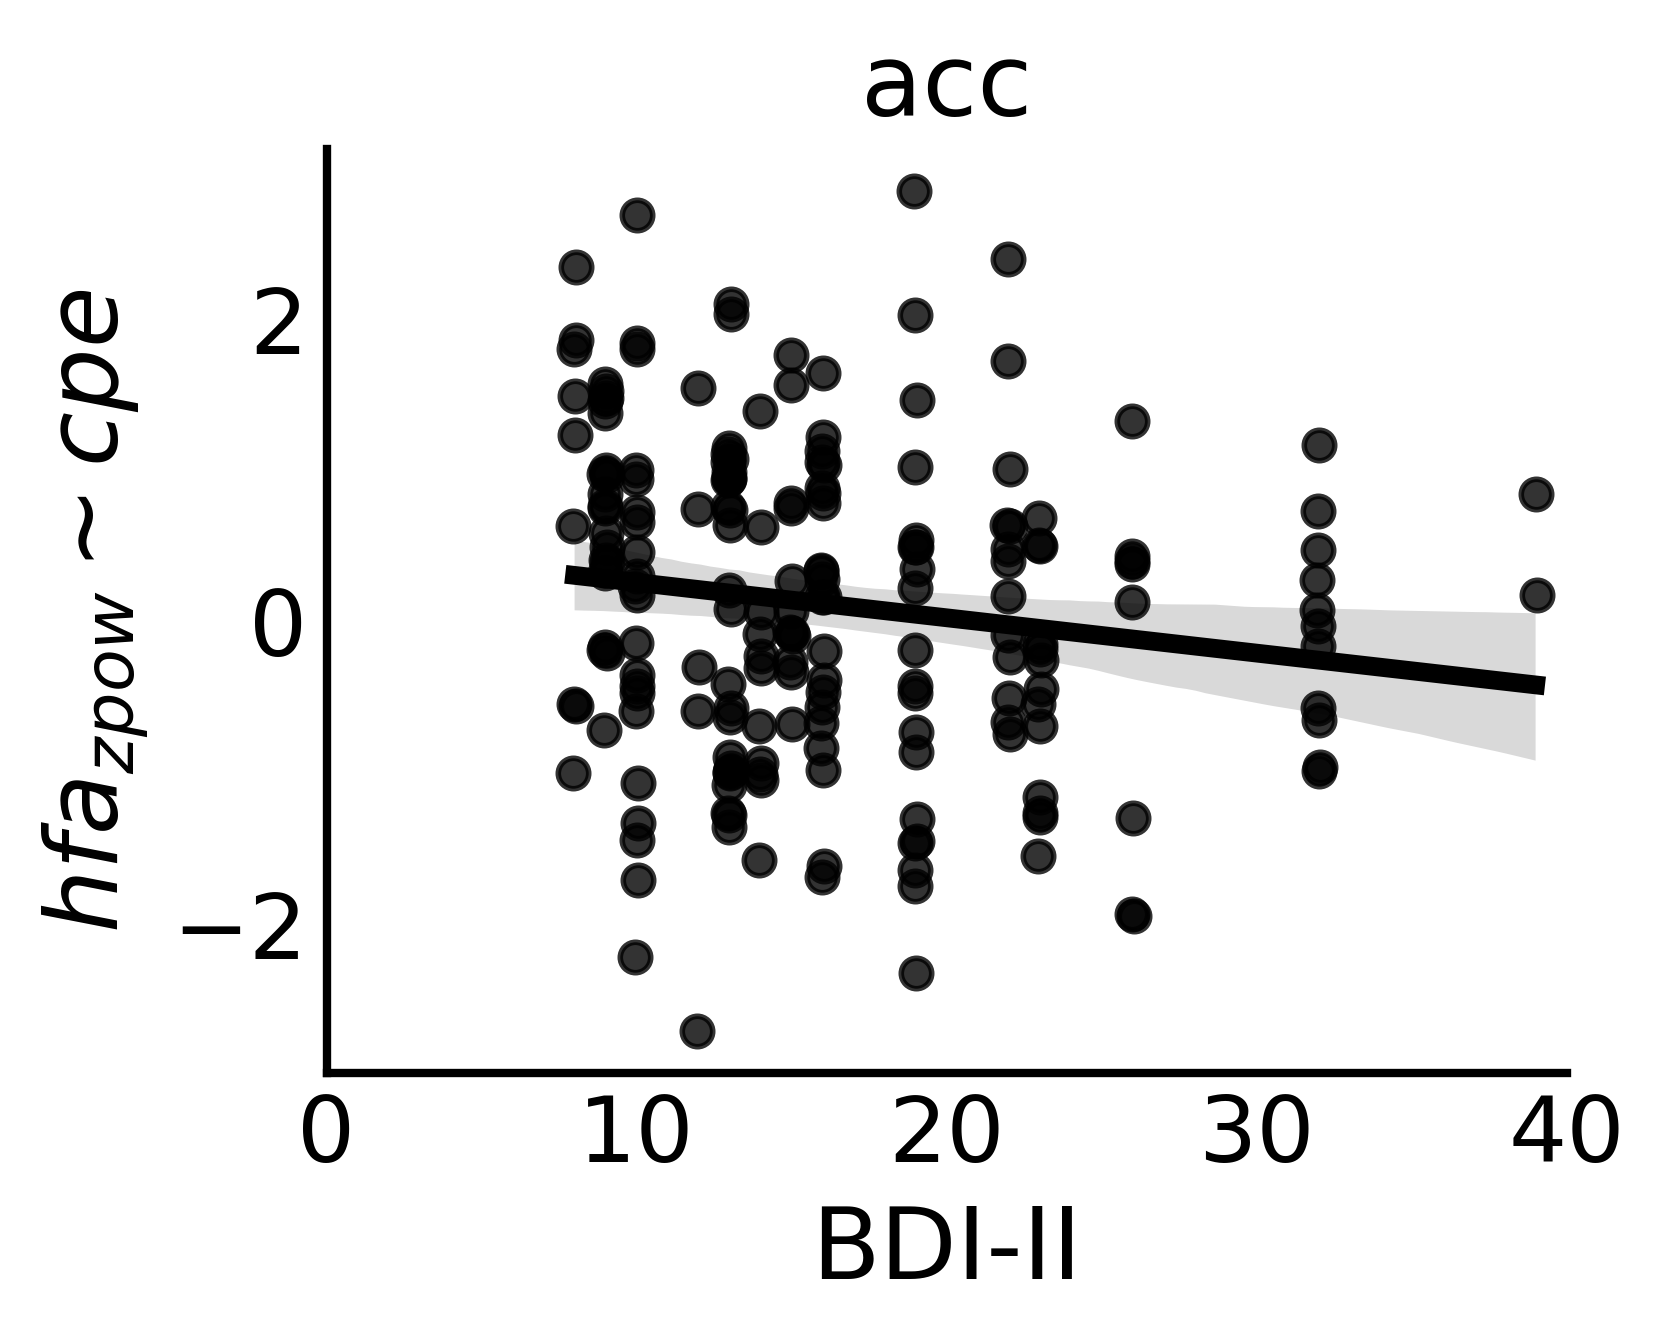

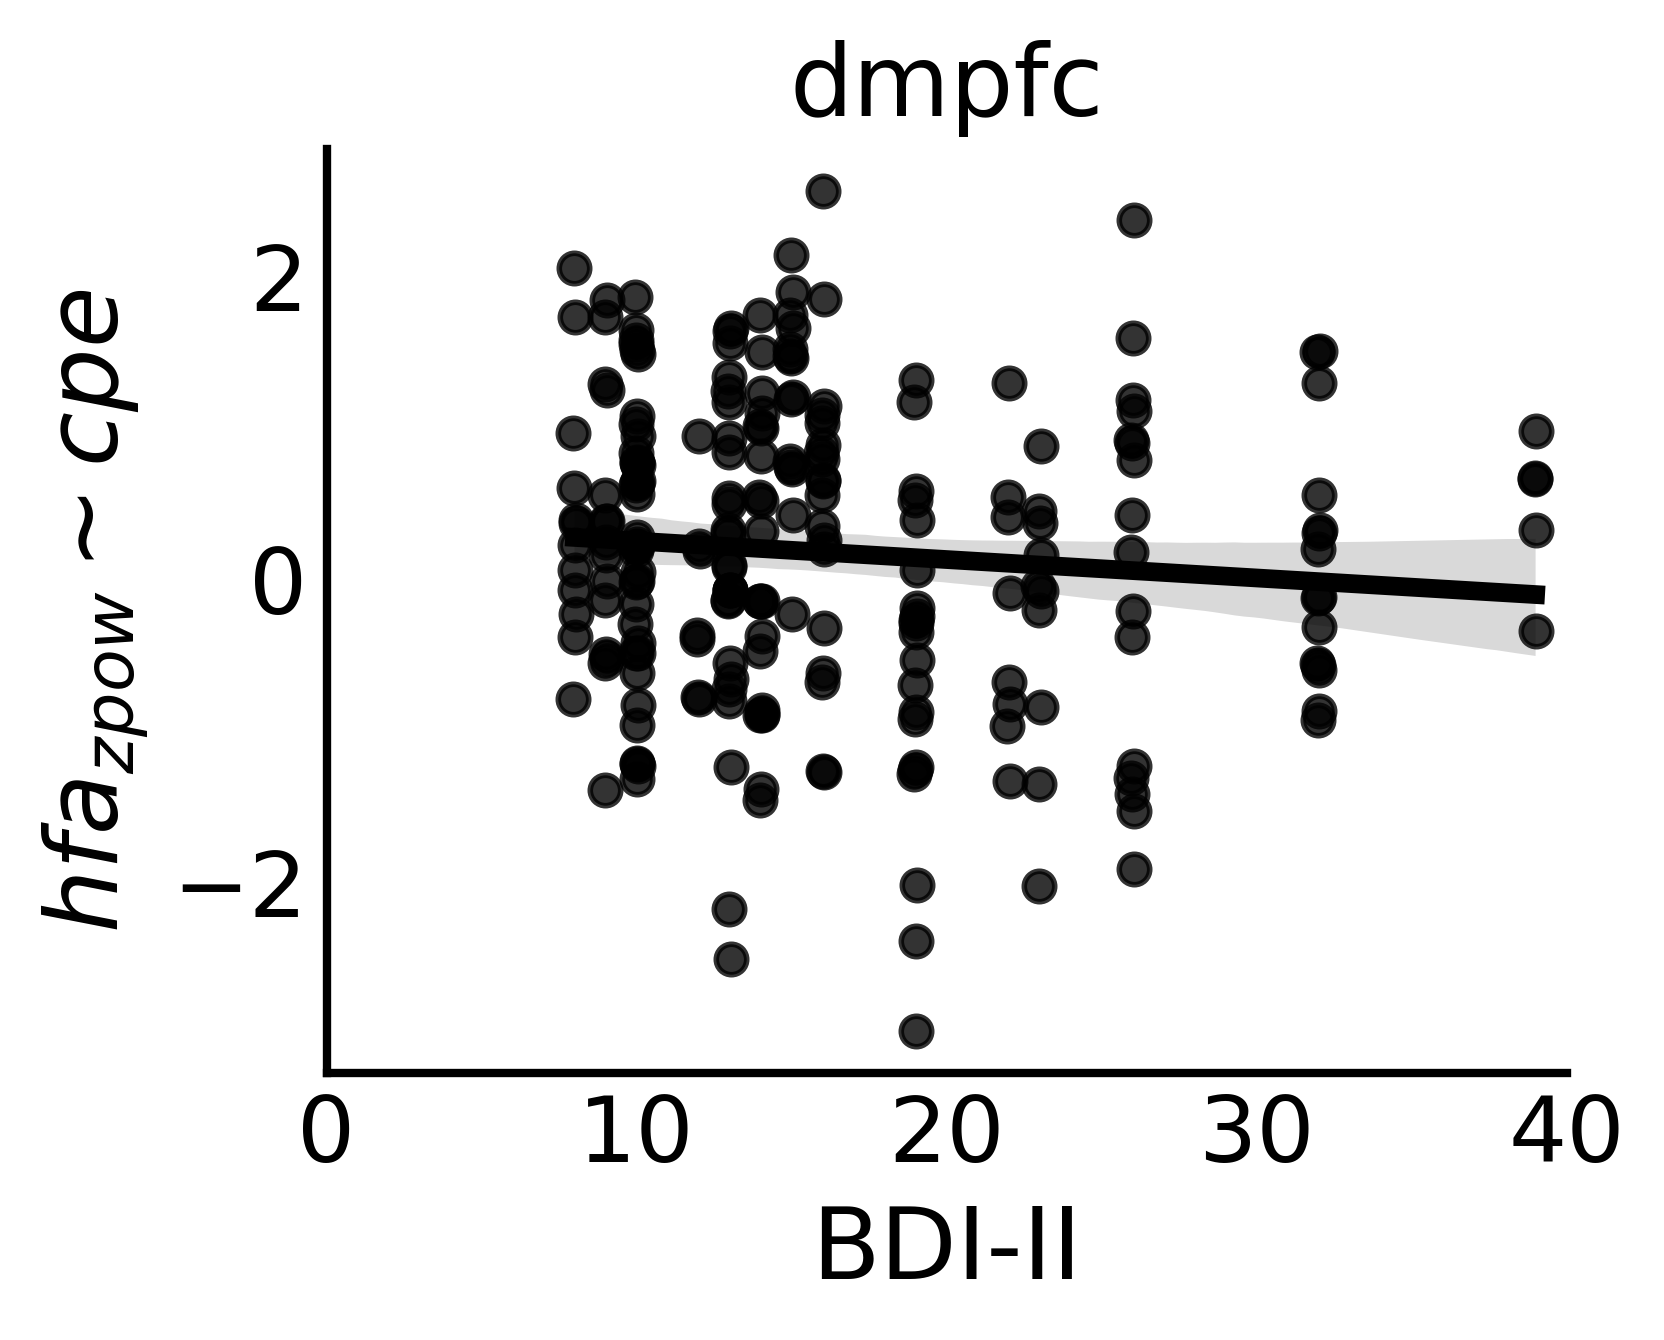

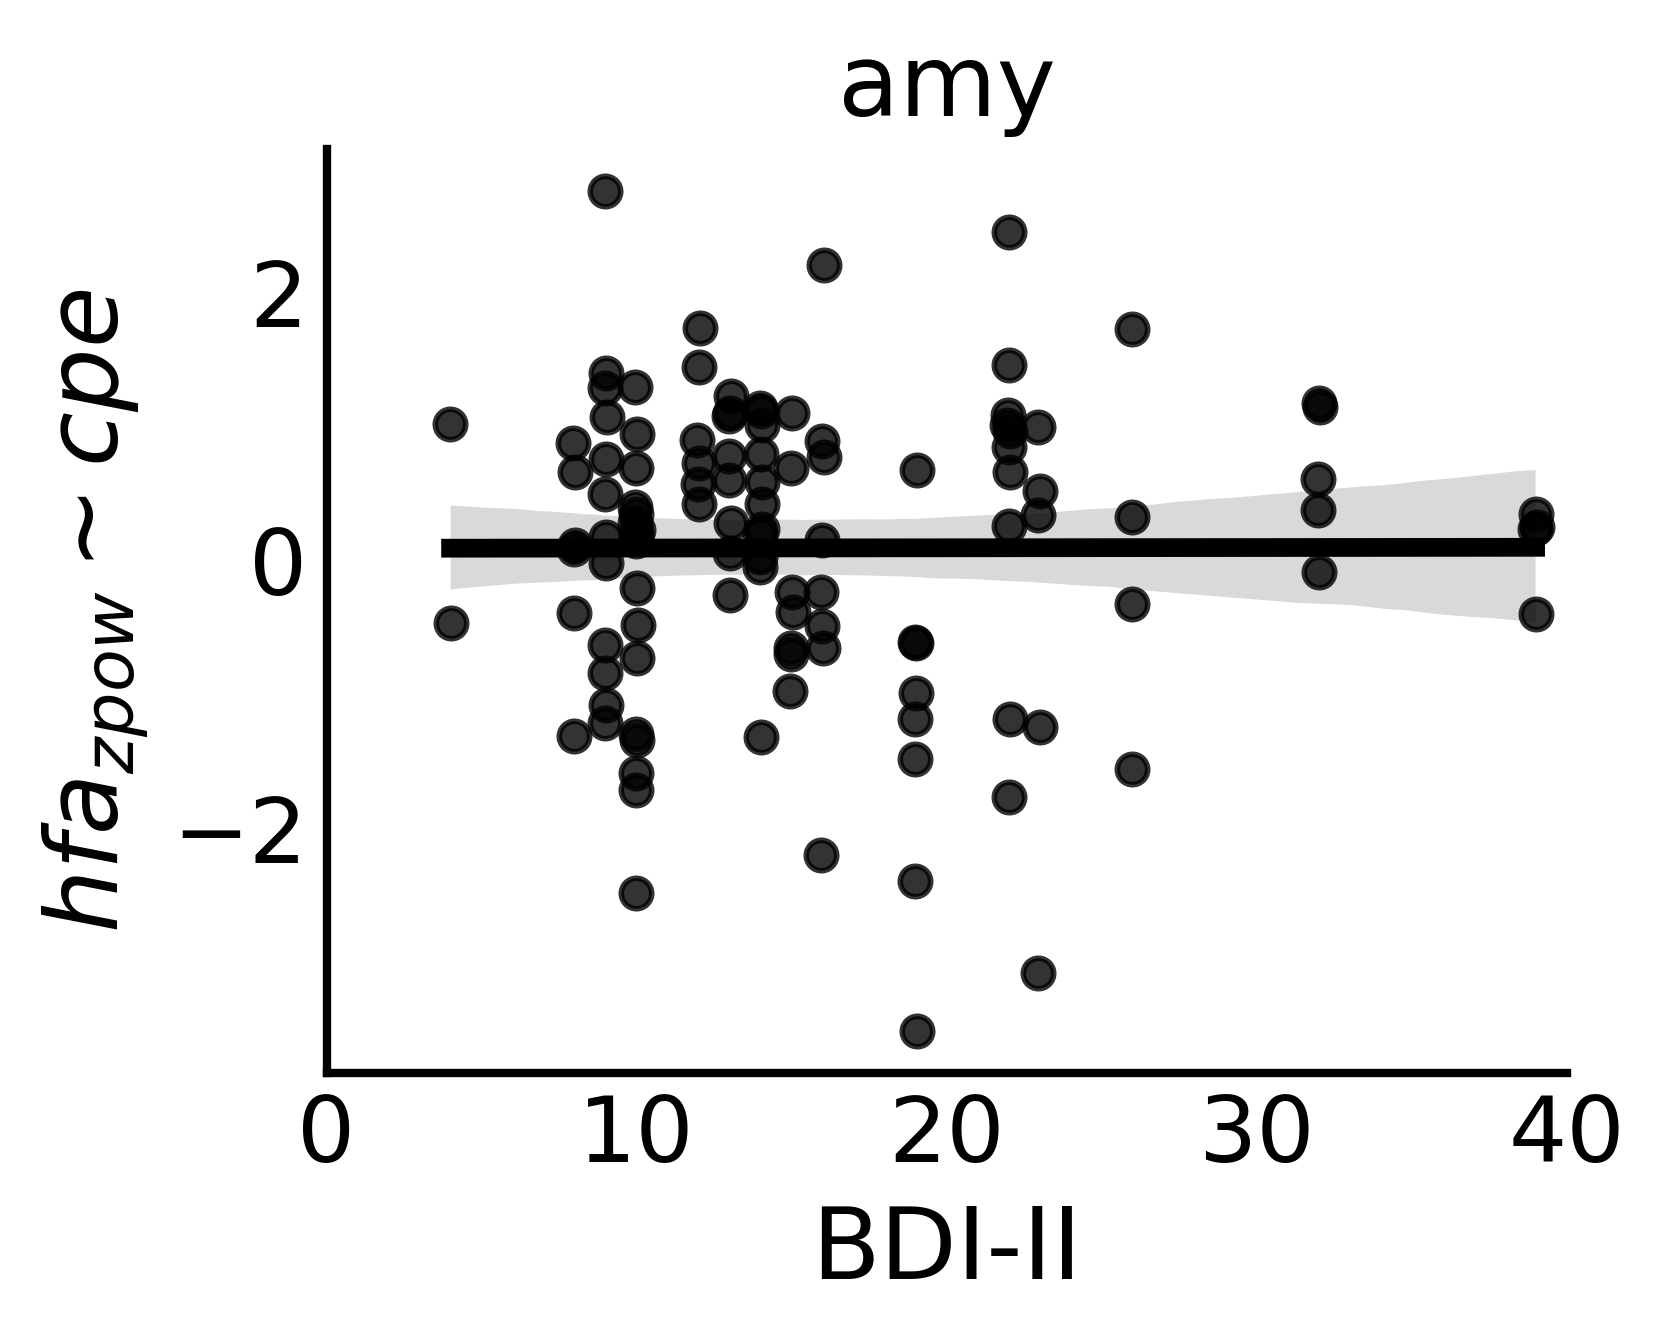

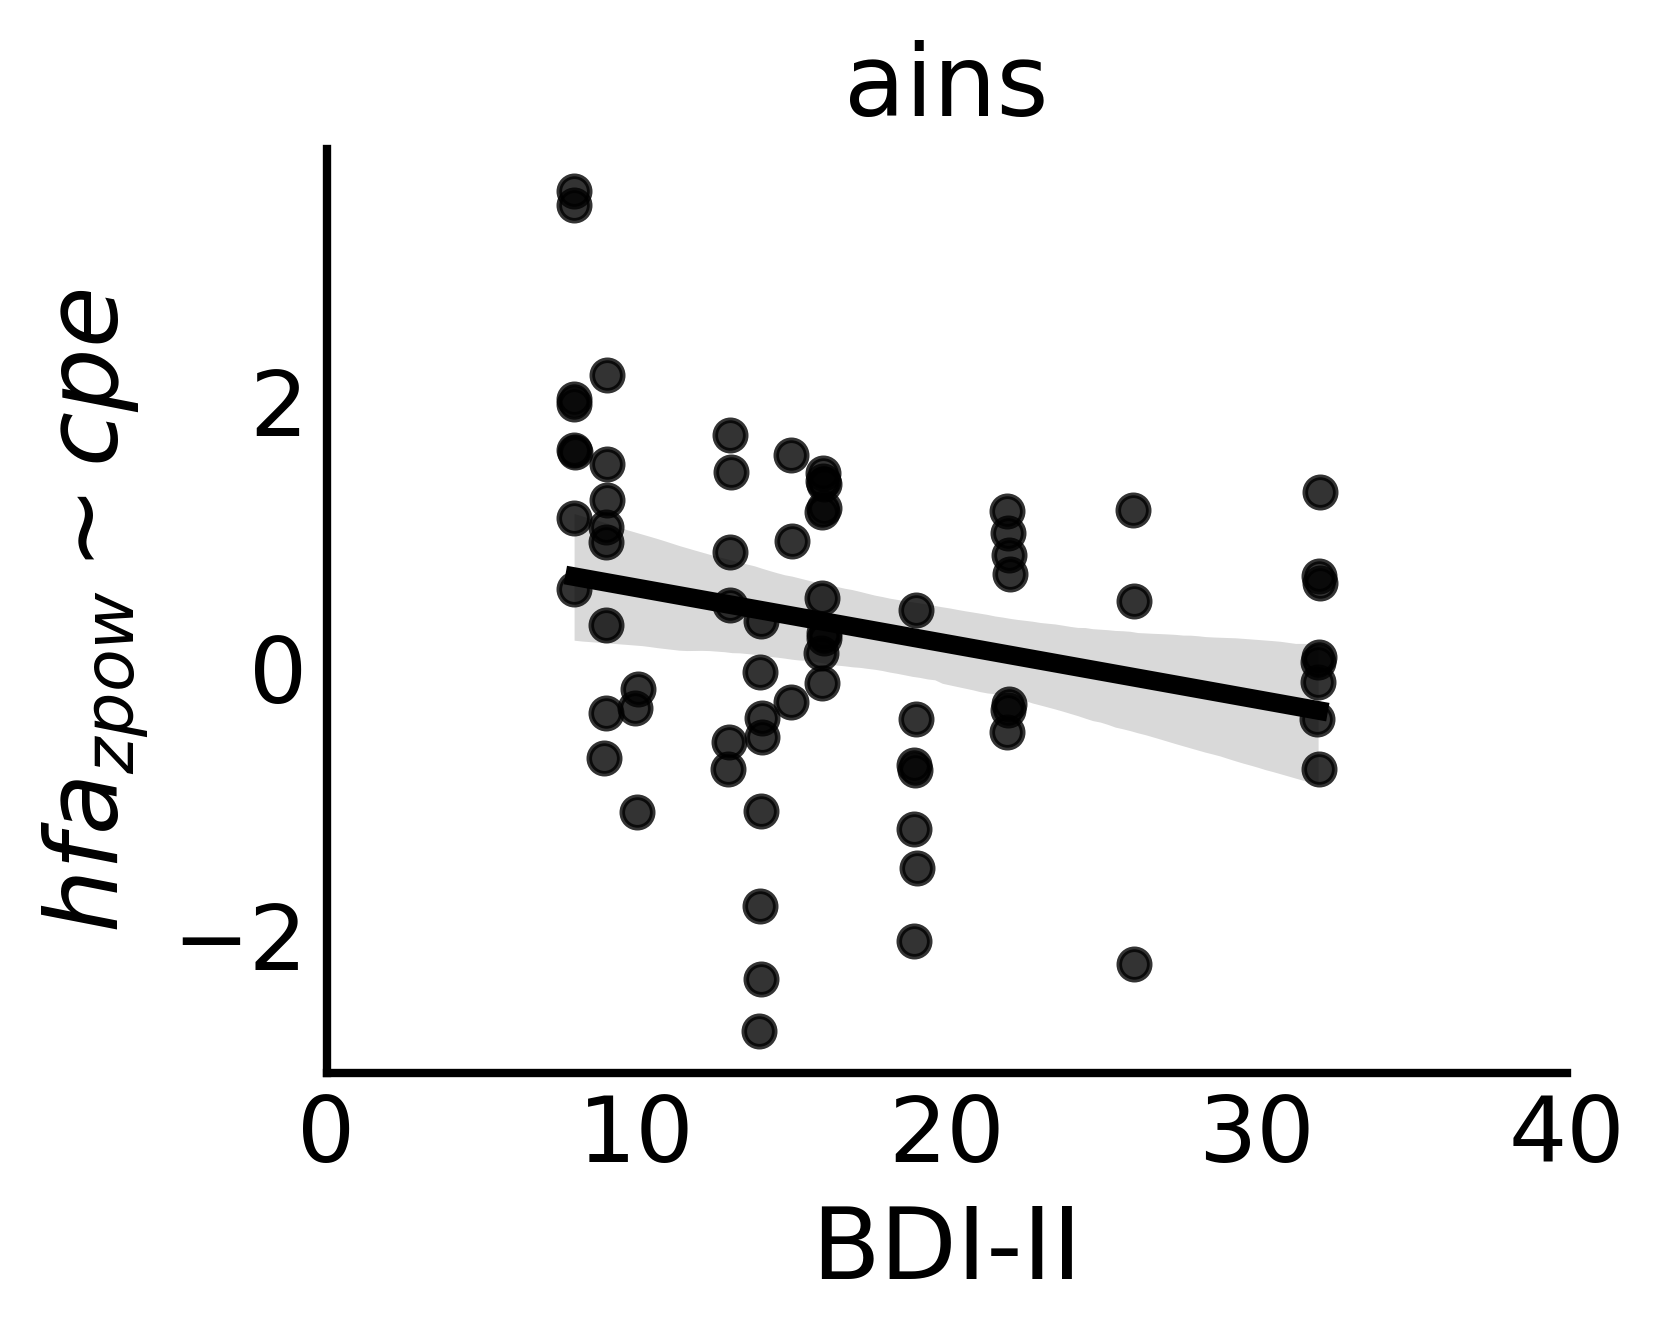

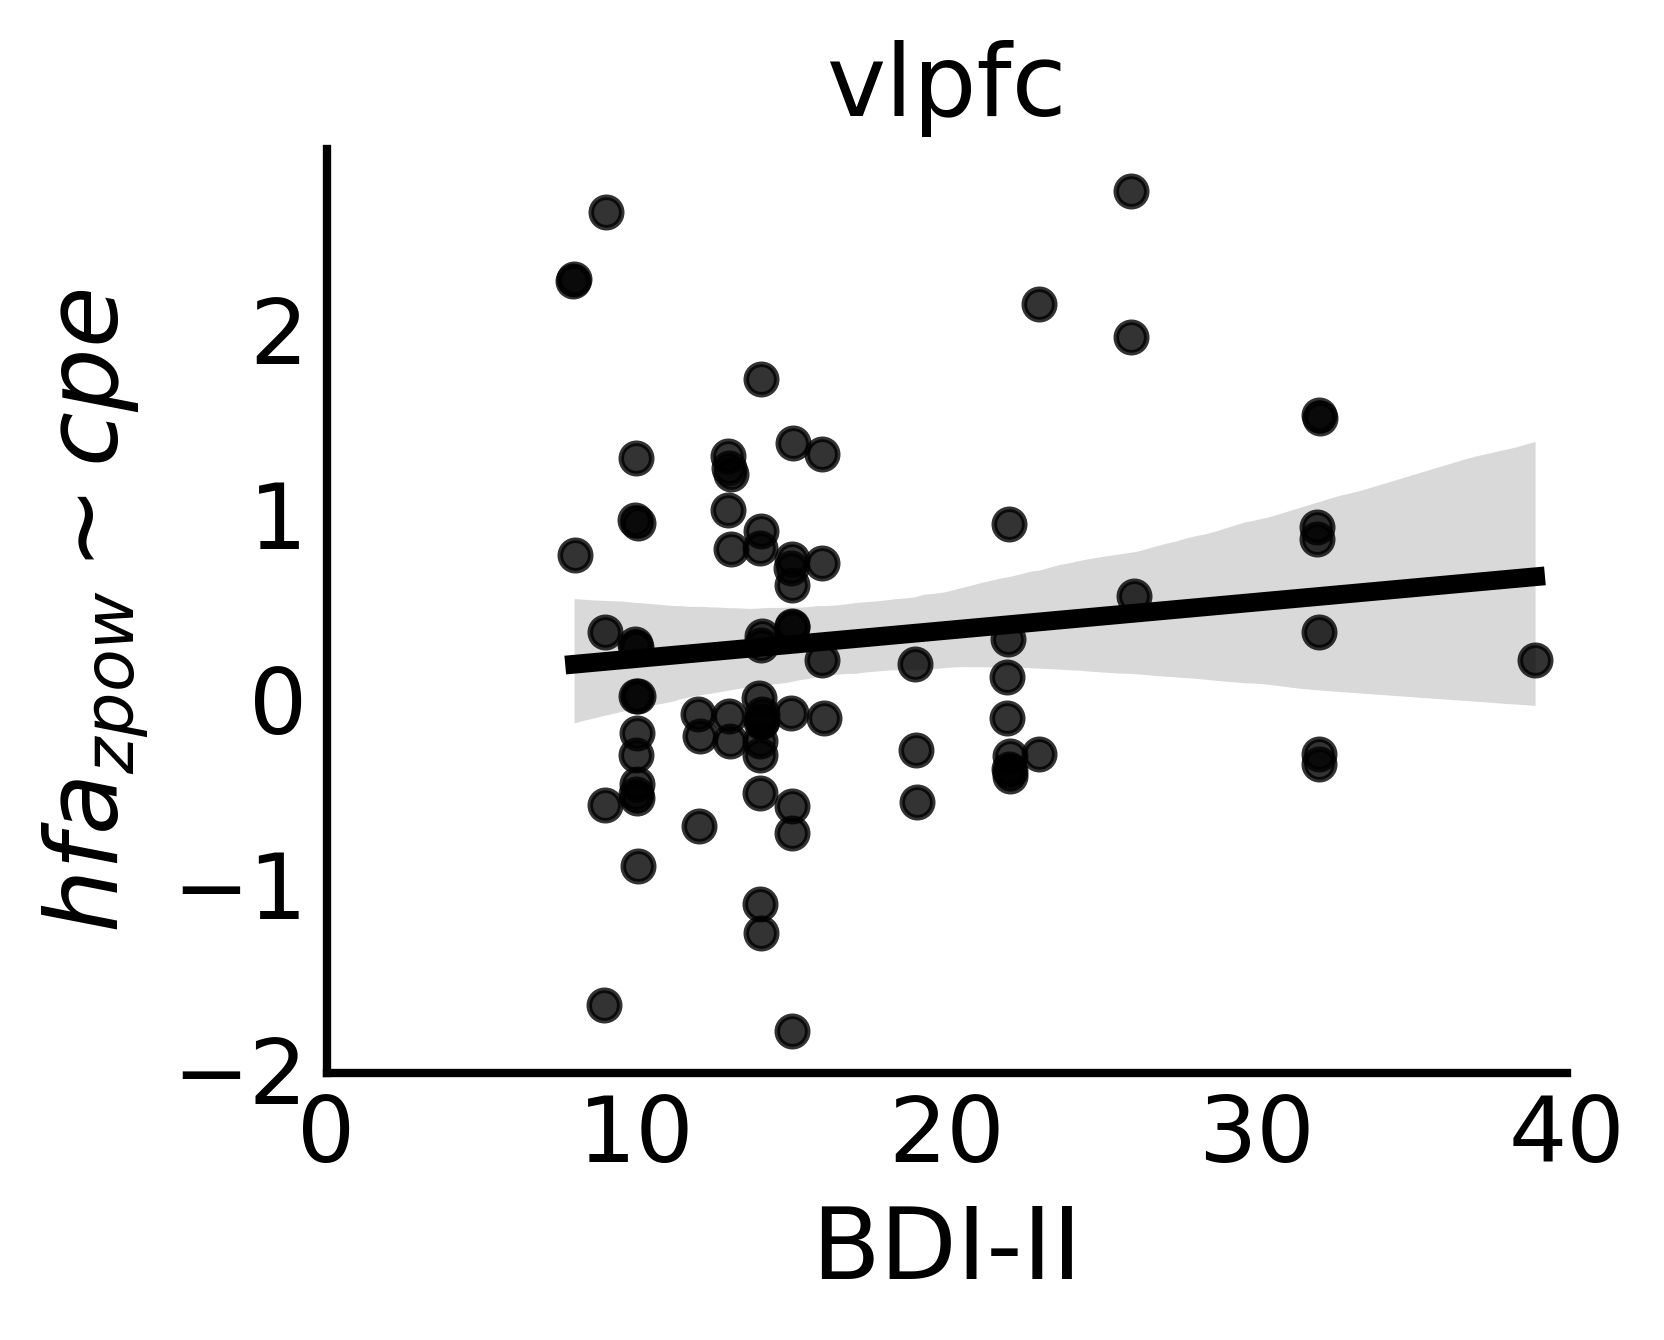

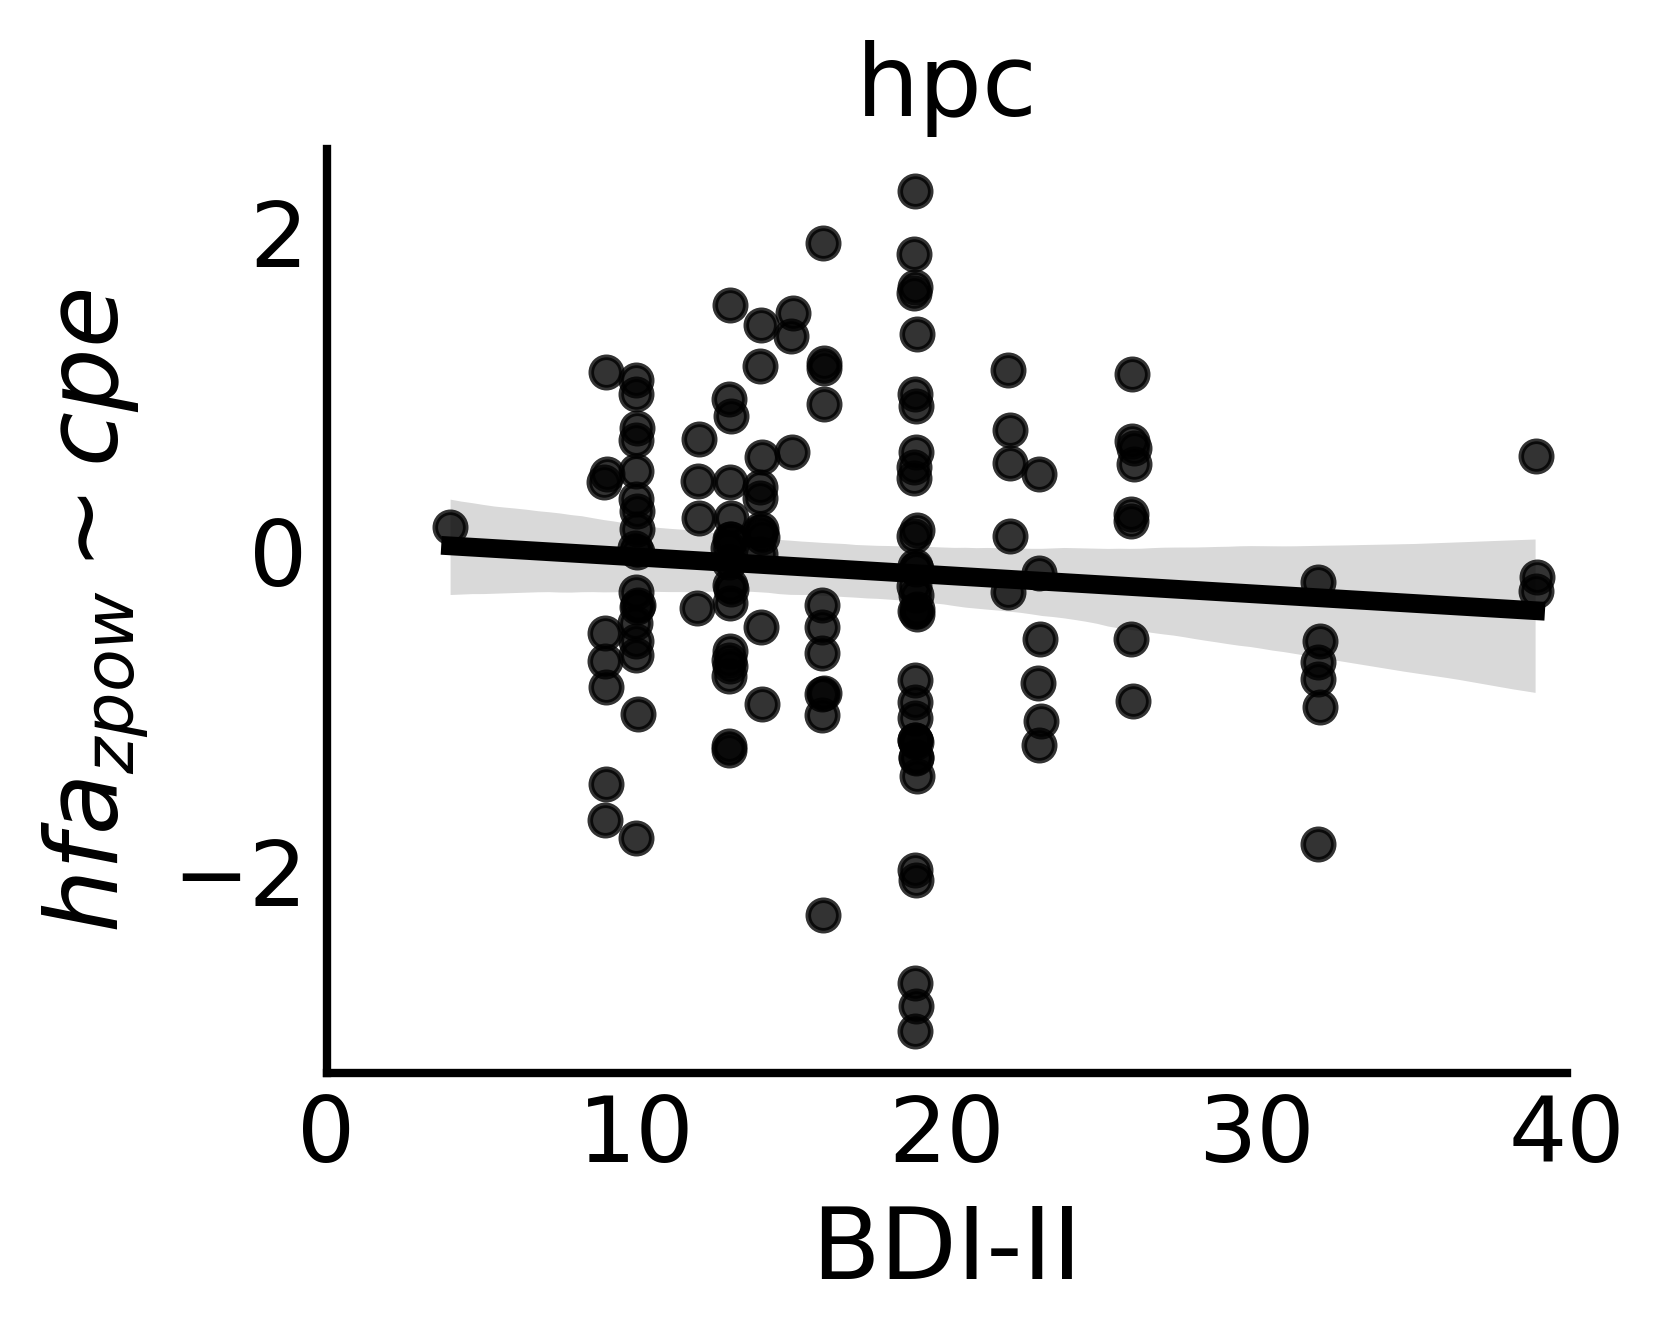

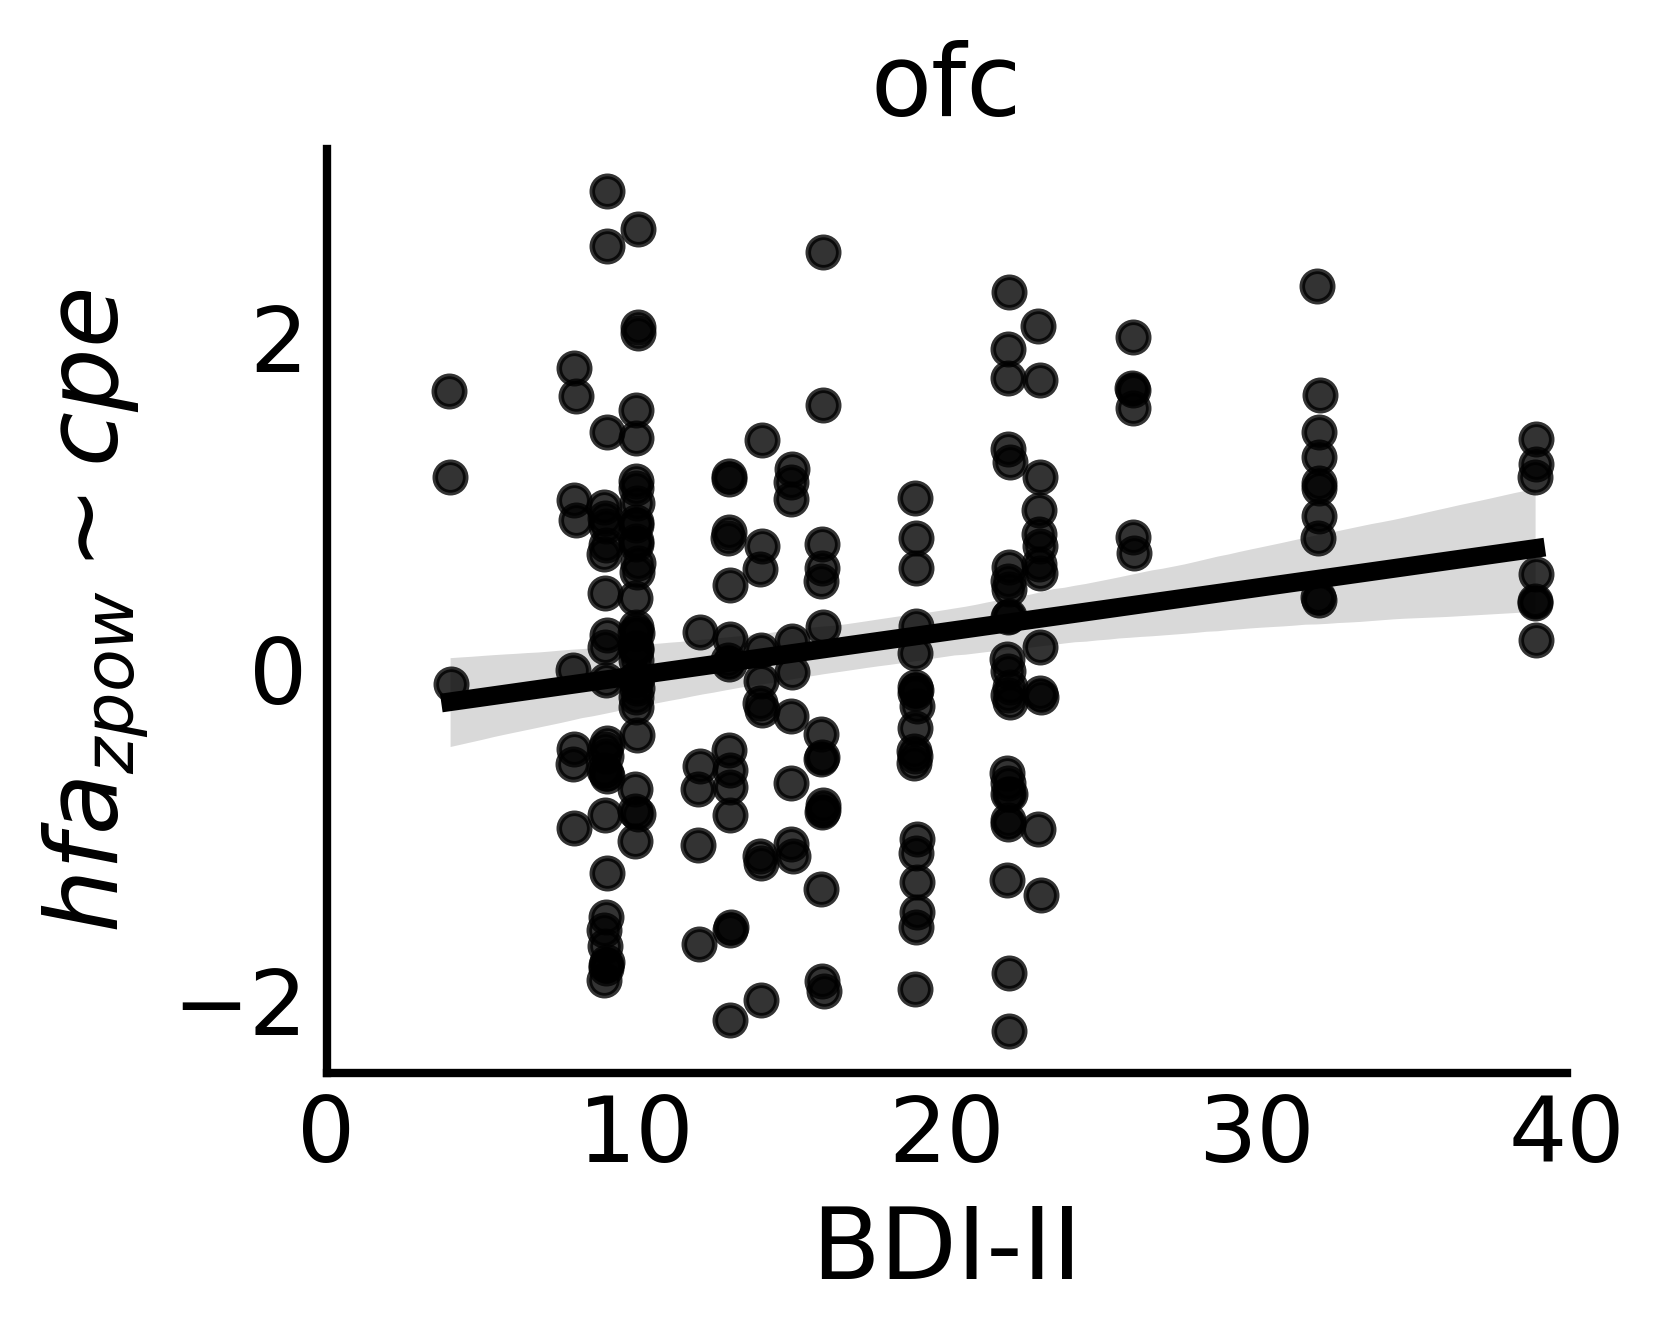

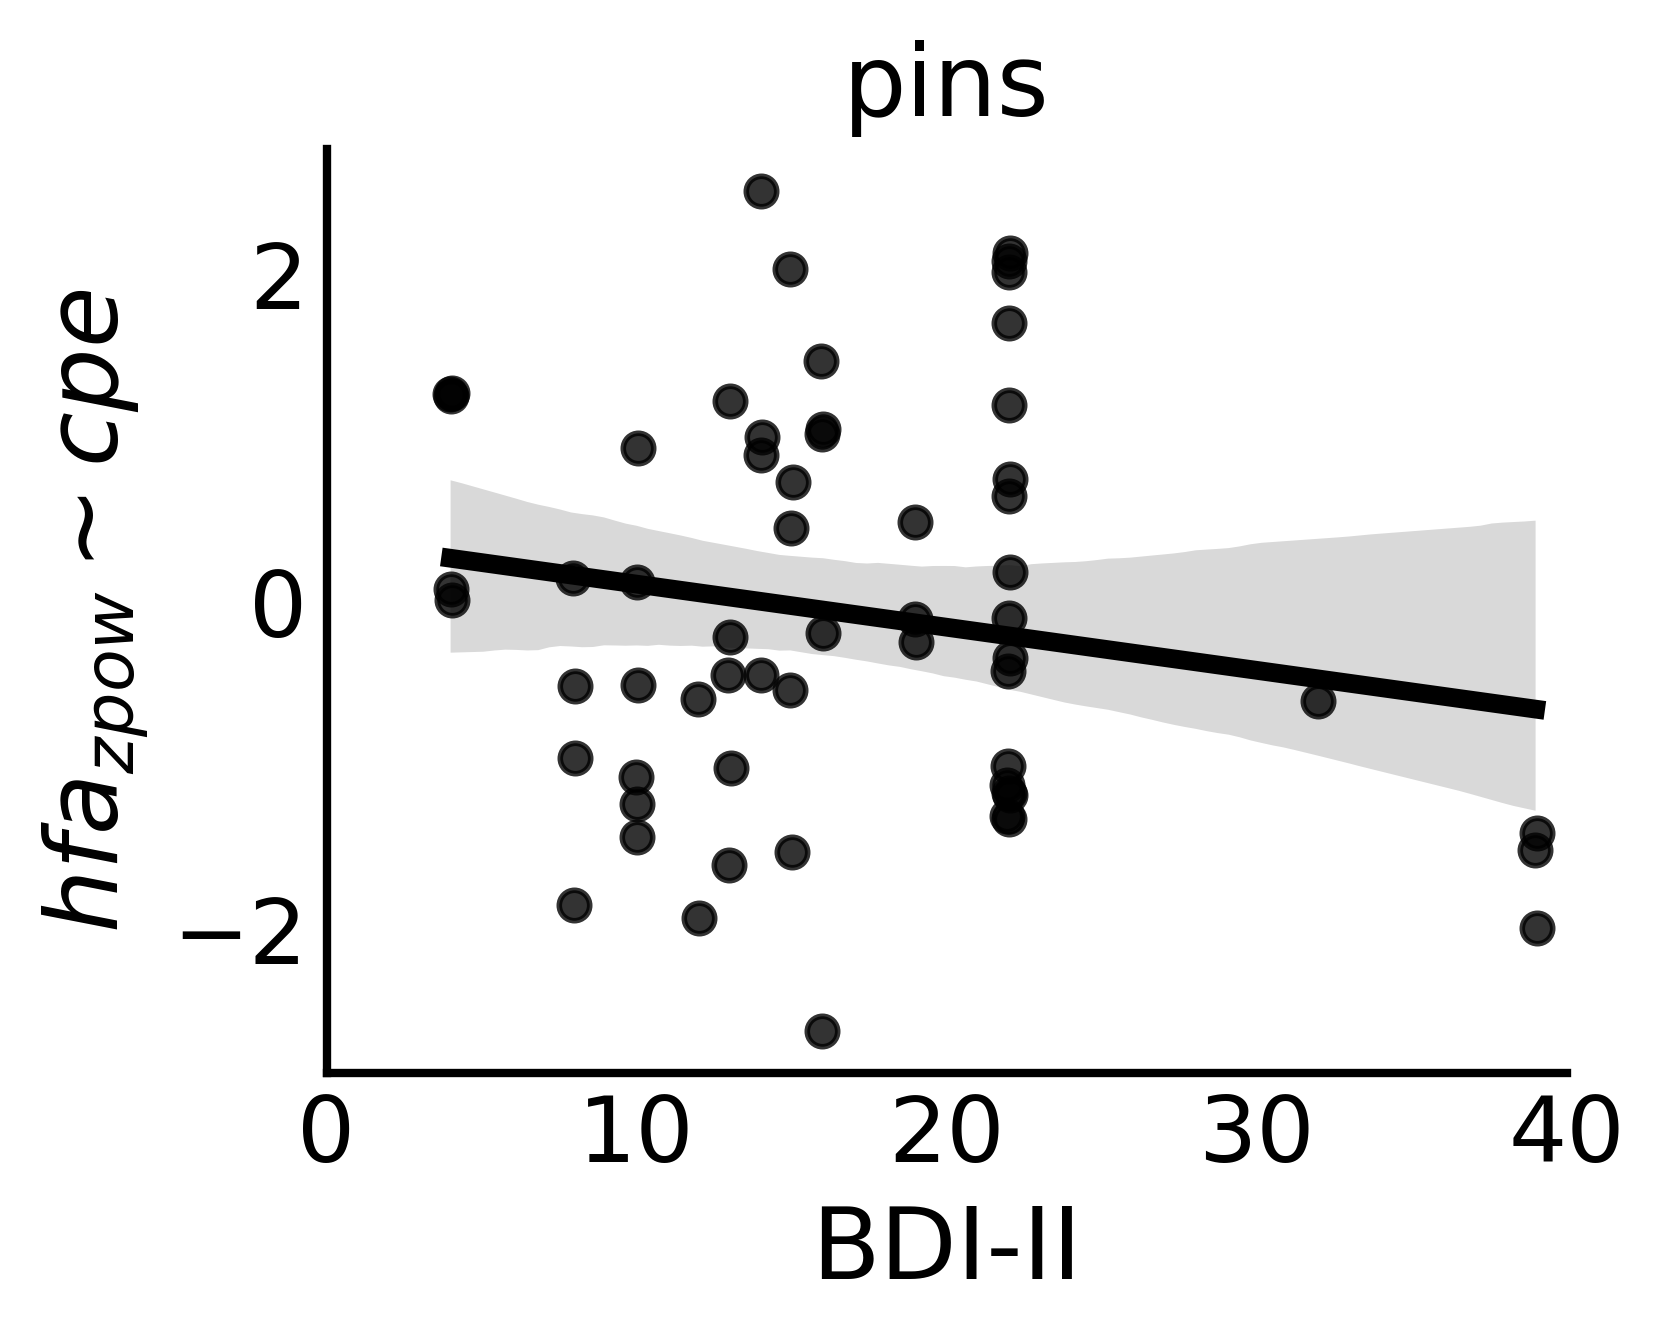

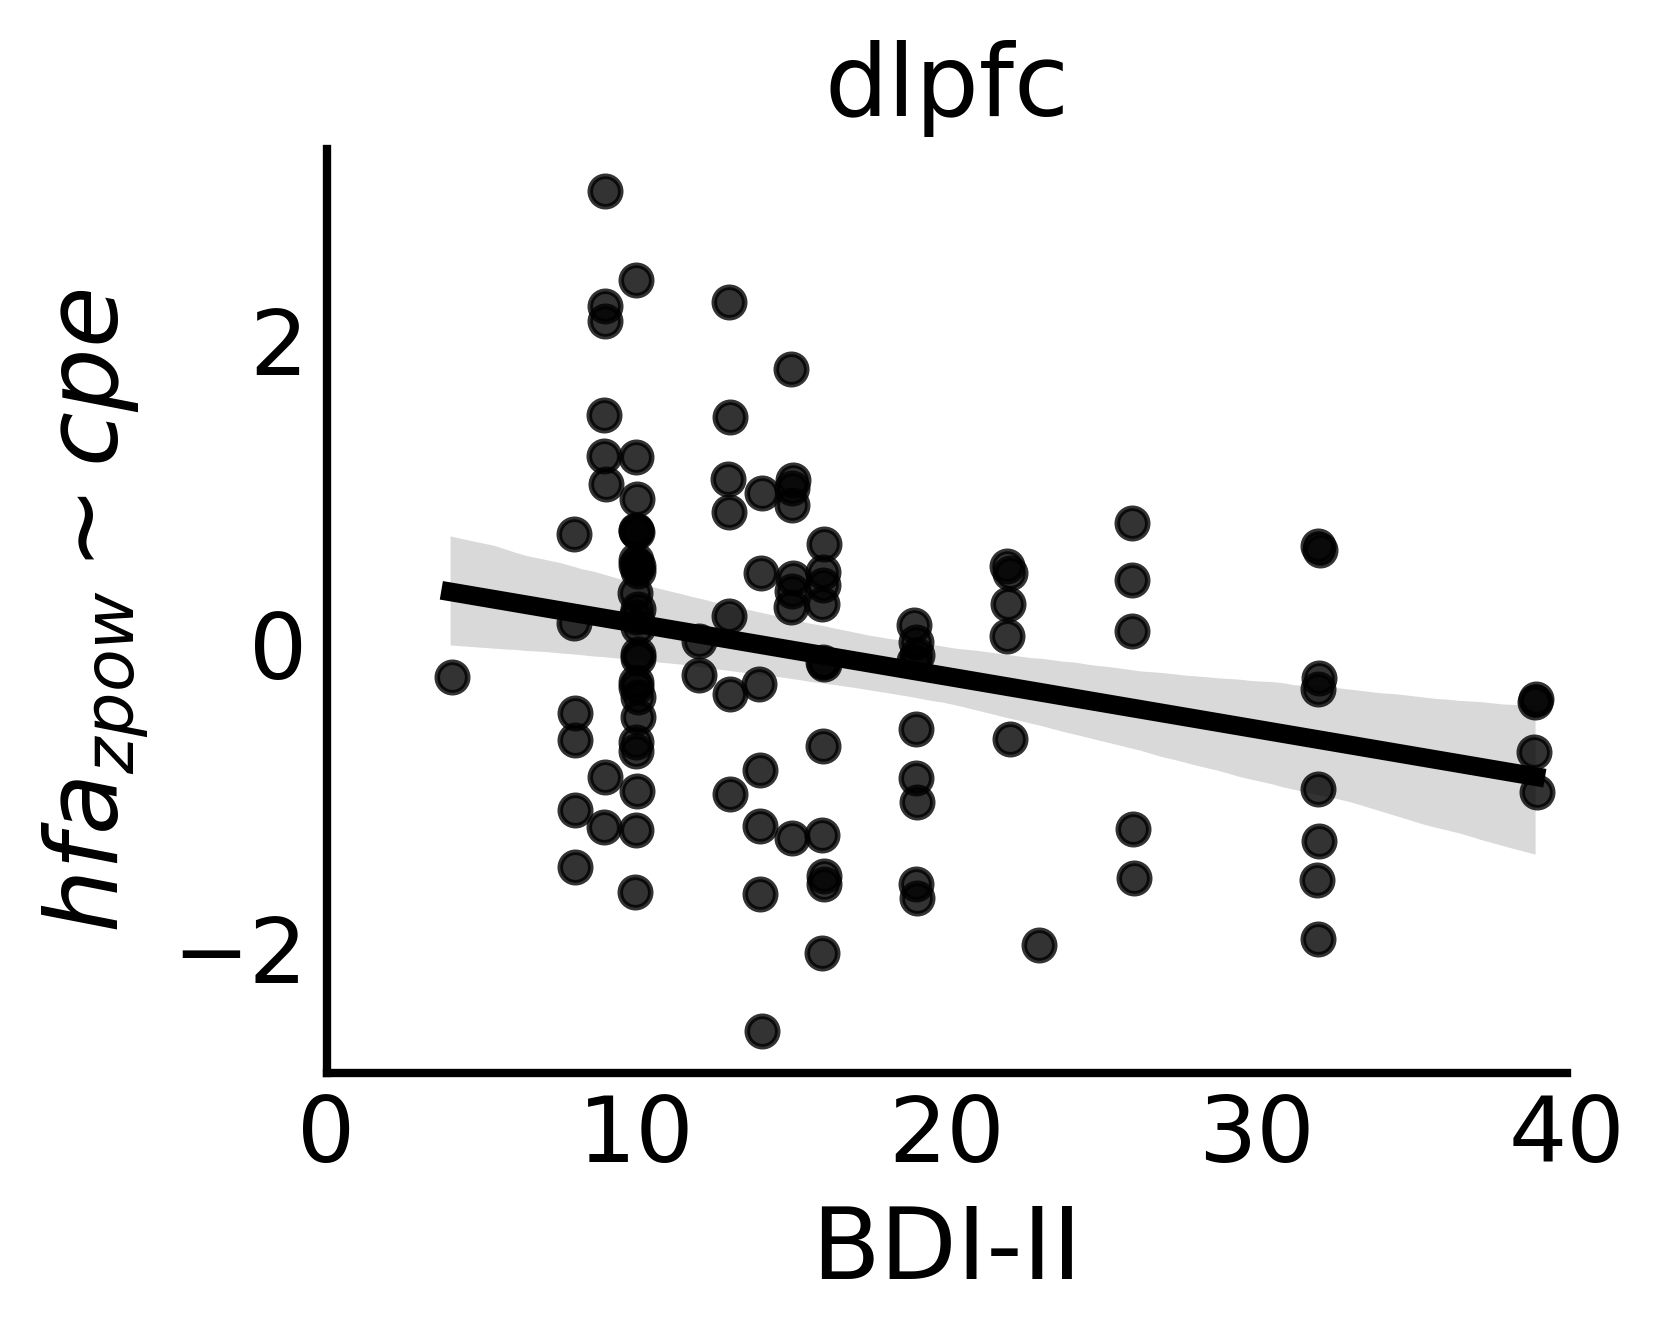

In [28]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_combomodel-Profit-cpe-bdi_cpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [29]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        11:37:28                                         
No. Iterations:                    15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9095      0.437     36.416     

In [30]:
# del cpe_var

# Profit Results

In [31]:
sig_data = results[results.P_Value_Profit < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0      MS002_lacas1-lacas2   MS002    acc   14                     0.031481   
4      MS002_lacas5-lacas6   MS002    acc   14                     0.031800   
5      MS002_lacas6-lacas7   MS002  dmpfc   14                     0.018862   
8     MS002_lacas9-lacas10   MS002  dmpfc   14                    -0.022073   
12     MS002_laims1-laims2   MS002   ains   14                     0.034774   
...                    ...     ...    ...  ...                          ...   
1173       DA039_rof2-rof3   DA039    ofc   22                    -0.013858   
1174       DA039_rof3-rof4   DA039    ofc   22                     0.024157   
1175       DA039_rof4-rof5   DA039    ofc   22                     0.018879   
1176       DA039_rof5-rof6   DA039    ofc   22                    -0.000623   
1177       DA039_rof6-rof7   DA039  dlpfc   22                    -0.032041   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.035772                  -0.029481   
4                                  -0.027026                  -0.070554   
5                                  -0.017144                  -0.045605   
8                                  -0.018822                   0.024388   
12                                 -0.027565                  -0.094876   
...                                      ...                        ...   
1173                               -0.008144                  -0.004860   
1174                               -0.045397                  -0.047017   
1175                               -0.035342                  -0.028758   
1176                               -0.014235                   0.001022   
1177                               -0.012736                  -0.038639   

      Original_Estimate_Profit  Original_Estimate_cpe  \
0                     0.082813              -0.004988   
4                     0.074491              -0.036509   
5                     0.090319              -0.034526   
8                    -0.104648               0.040919   
12                    0.126246              -0.064235   
...                        ...                    ...   
1173                  0.068788              -0.006455   
1174                  0.129739              -0.026961   
1175                  0.117282              -0.021946   
1176                  0.079339              -0.015838   
1177                  0.073407              -0.014444   

      Permuted_Mean_Intercept  ...  Z_Score_TrialEV  Z_Score_Profit  \
0                    0.006794  ...        -1.014304        2.588456   
4                    0.013566  ...        -2.365300        2.464328   
5                    0.007372  ...        -1.396612        2.660260   
8                   -0.035670  ...         0.532127       -2.289220   
12                   0.015850  ...        -3.216302        3.932787   
...                       ...  ...              ...             ...   
1173                -0.015867  ...        -0.115657        2.306235   
1174                 0.005324  ...        -1.252803        2.890455   
1175                 0.005109  ...        -0.829298        2.997255   
1176                -0.005469  ...         0.027300        2.318442   
1177                -0.038234  ...        -1.577915        2.439820   

      Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
0       -0.228201           0.102150                      0.100441   
4       -1.574568           0.226912                      0.224093   
5       -1.383766           0.441577                      0.432869   
8        1.228771           0.520302                      0.530354   
12      -2.719469           0.189102                      0.182545   
...           ...                ...                           ...   
1173    -0.195436           0.785247                      0.670756   
1174    -0.753283           0.099453                      0.0869

In [32]:
sig_data.roi.value_counts()



roi
ofc      37
dmpfc    22
acc      21
dlpfc    17
pins     10
amy      10
ains      9
vlpfc     8
hpc       6
Name: count, dtype: int64

In [33]:
sig_data.roi.unique()



array(['acc', 'dmpfc', 'ains', 'ofc', 'vlpfc', 'pins', 'dlpfc', 'amy',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [34]:
# add mask col for sig cpe elecs 
results['Profit_sig']   = results['P_Value_Profit'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.031481   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.031584   
2  MS002_lacas3-lacas4   MS002  acc   14                    -0.006661   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.012905   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.031800   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.035772                  -0.029481   
1                               -0.047934                  -0.032385   
2                               -0.002486                  -0.015895   
3                               -0.017408                  -0.012853   
4                               -0.027026                  -0.070554   

   Original_Estimate_Profit  Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.082813              -0.004988                 0.006794   
1                  0.038938               0.002566                -0.001269   
2                 -0.003642              -0.013389                -0.008057   
3                 -0.009086              -0.022870                 0.000319   
4                  0.074491              -0.036509                 0.013566   

   ...  Z_Score_Profit  Z_Score_cpe  P_Value_Intercept  \
0  ...        2.588456    -0.228201           0.102150   
1  ...        1.264629     0.066425           0.034668   
2  ...       -0.091299    -0.685208           0.913194   
3  ...       -0.227621    -1.008087           0.391343   
4  ...        2.464328    -1.574568           0.226912   

   P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_Profit  P_Value_cpe  \
0                      0.100441         0.310438        0.009641     0.819490   
1                      0.034703         0.266942        0.206004     0.947039   
2                      0.912806         0.542393        0.927255     0.493212   
3                      0.388926         0.632396        0.819941     0.313413   
4                      0.224093         0.018015        0.013727     0.115356   

   cpe_sig  bdi_split  Profit_sig  
0        0          0           1  
1        0          0           0  
2        0          0           0  
3        0          0           0  
4        0          0           1  

[5 rows x 32 columns]

In [35]:
Profit_var = 'Z_Score_Profit'

In [36]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [37]:
results.groupby('roi').agg('mean',numeric_only=True)[Profit_var][bar_order]



roi
dlpfc    0.320388
vlpfc   -0.252918
dmpfc   -0.144073
ofc      0.523757
ains     0.066916
pins     0.125107
acc      0.421544
amy      0.121895
hpc      0.180806
Name: Z_Score_Profit, dtype: float64

In [38]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[Profit_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.Profit_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].Profit_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [39]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     21  0.108808              4    4.978958  1.418602e-06   
1  dmpfc      225     22  0.097778              3   -1.715013  8.772582e-02   
2    amy      113     10  0.088496              1    1.085415  2.800686e-01   
3   ains       71      9  0.126761              2    0.412151  6.814880e-01   
4  vlpfc       82      8  0.097561              1   -2.010111  4.774795e-02   
5    hpc      135      6  0.044444              0    2.018110  4.557599e-02   
6    ofc      202     37  0.183168             13    5.359790  2.273631e-07   
7   pins       60     10  0.166667              1    0.715624  4.770464e-01   
8  dlpfc      107     17  0.158879              8    2.469133  1.514111e-02   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.074078            1.0    0.108808      0.0007  
1      0.067126            1.0    0.097778      0.0022  
2      0.048799            1.0    0.088496      0.0571  
3      0.067750            1.0    0.126761      0.0088  
4      0.049476            1.0    0.097561      0.0526  
5      0.019530            1.0    0.044444      0.6724  
6      0.139644            1.0    0.183168      0.0000  
7      0.093307            1.0    0.166667      0.0007  
8      0.103835            1.0    0.158879      0.0000

In [40]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     21  0.108808              4    4.978958  1.418602e-06   
1  dmpfc      225     22  0.097778              3   -1.715013  8.772582e-02   
3   ains       71      9  0.126761              2    0.412151  6.814880e-01   
6    ofc      202     37  0.183168             13    5.359790  2.273631e-07   
7   pins       60     10  0.166667              1    0.715624  4.770464e-01   
8  dlpfc      107     17  0.158879              8    2.469133  1.514111e-02   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.074078            1.0    0.108808      0.0007  
1      0.067126            1.0    0.097778      0.0022  
3      0.067750            1.0    0.126761      0.0088  
6      0.139644            1.0    0.183168      0.0000  
7      0.093307            1.0    0.166667      0.0007  
8      0.103835            1.0    0.158879      0.0000

# Plot Results

In [41]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodelProfit-cpe-Profit_coeff_barplot_{epoch_len}.pdf'


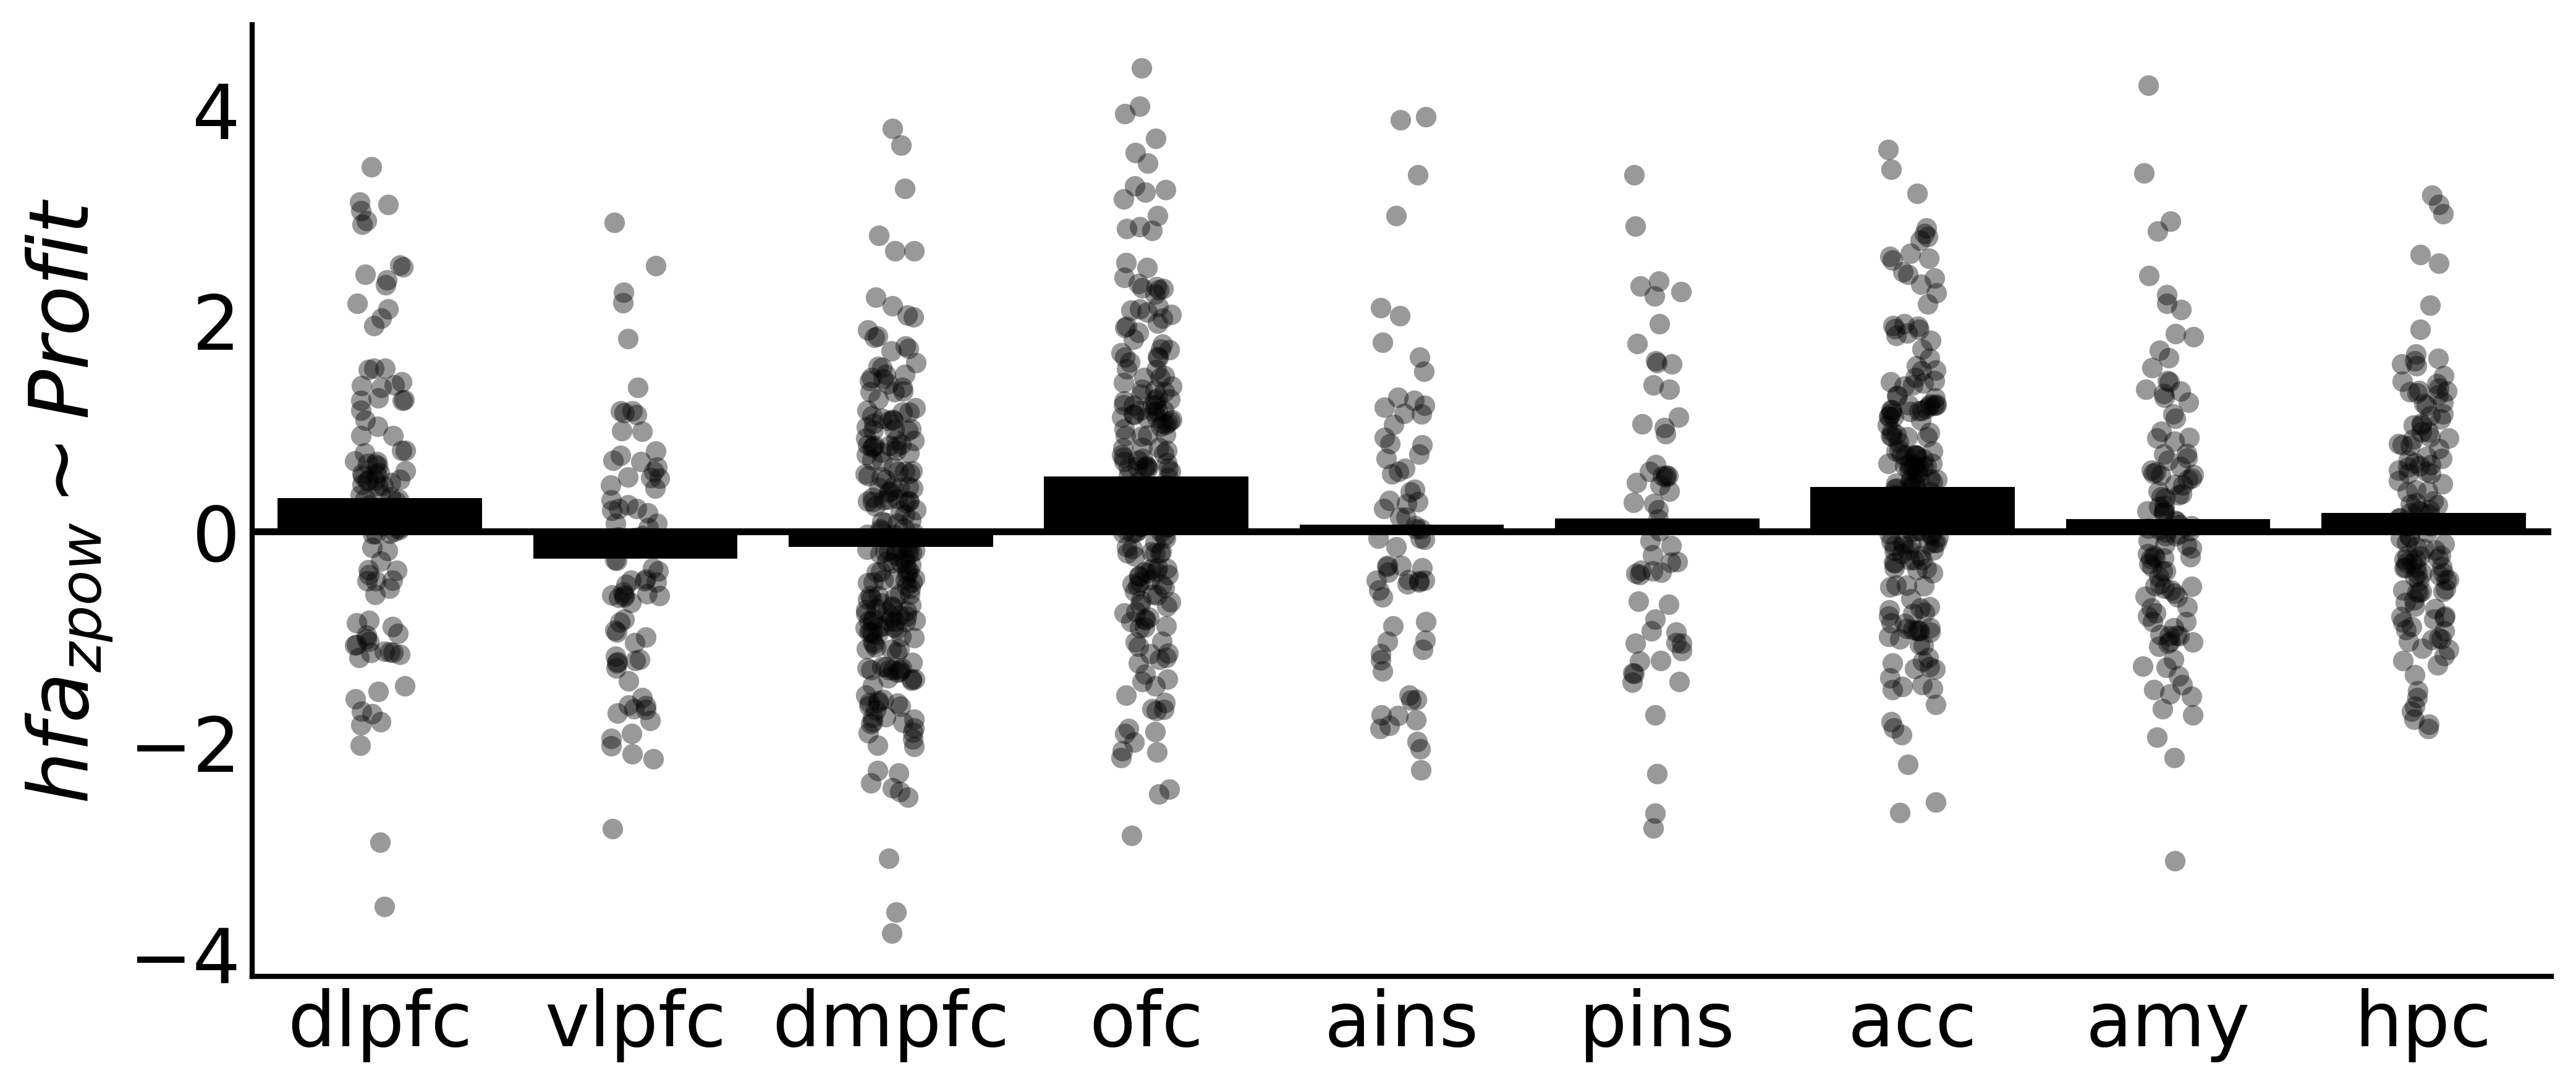

In [42]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim Profit$'


plot_roi_model_results(results,'roi',Profit_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

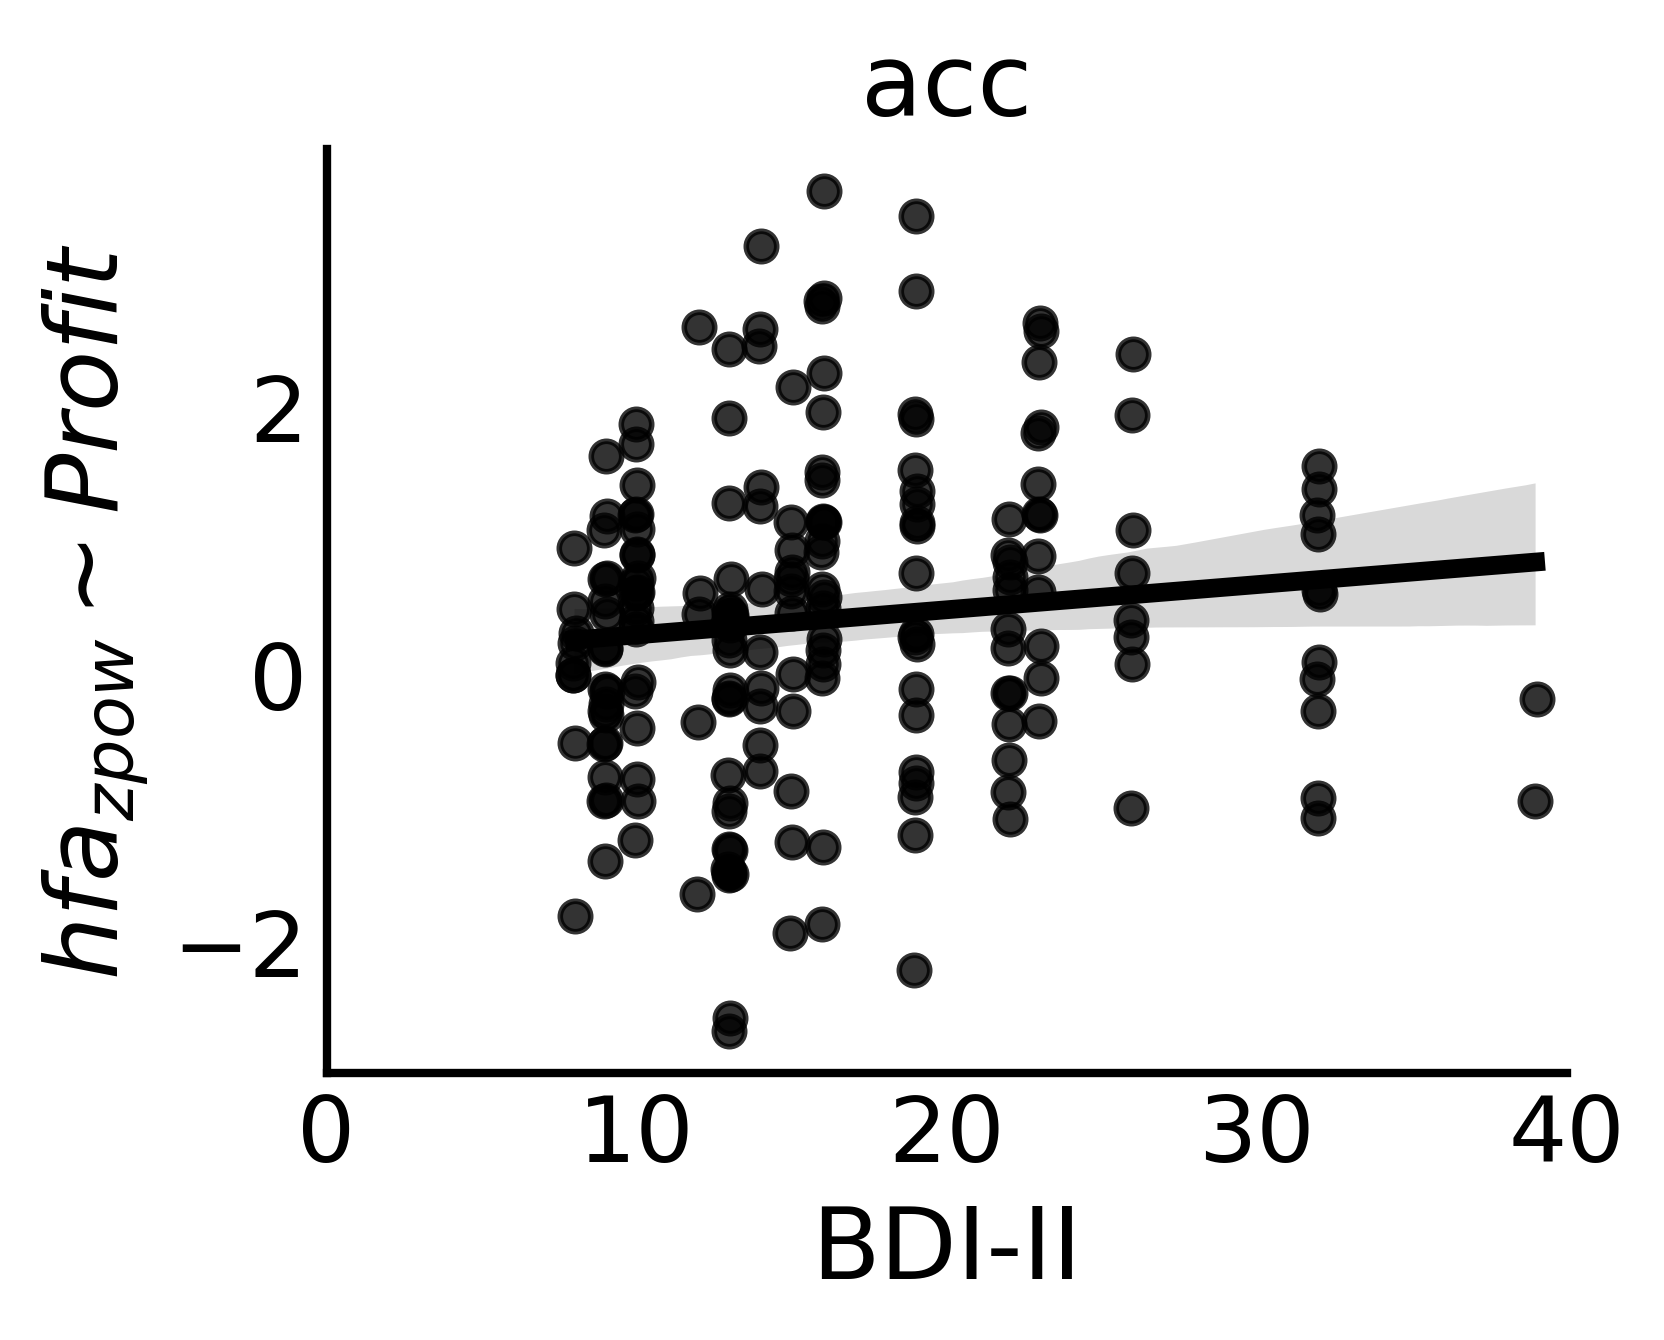

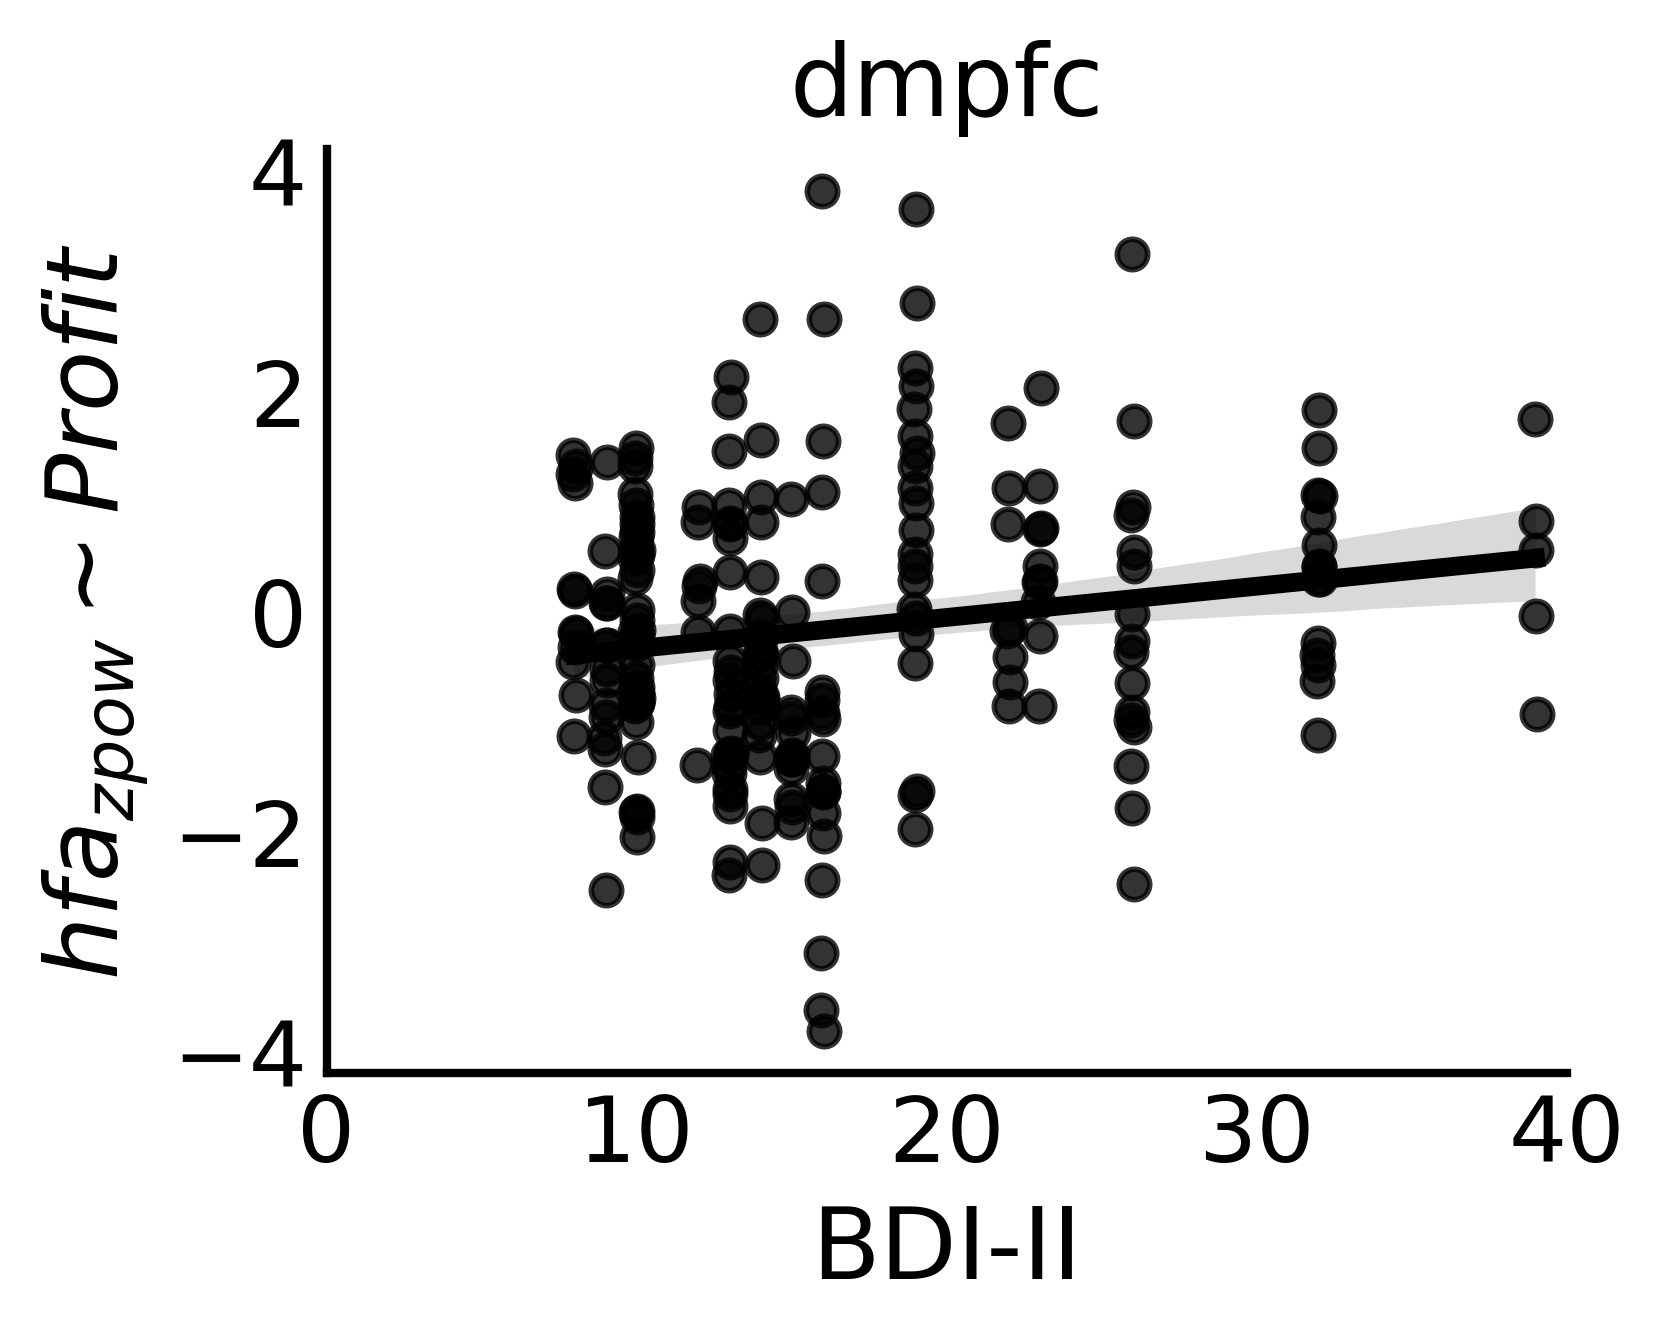

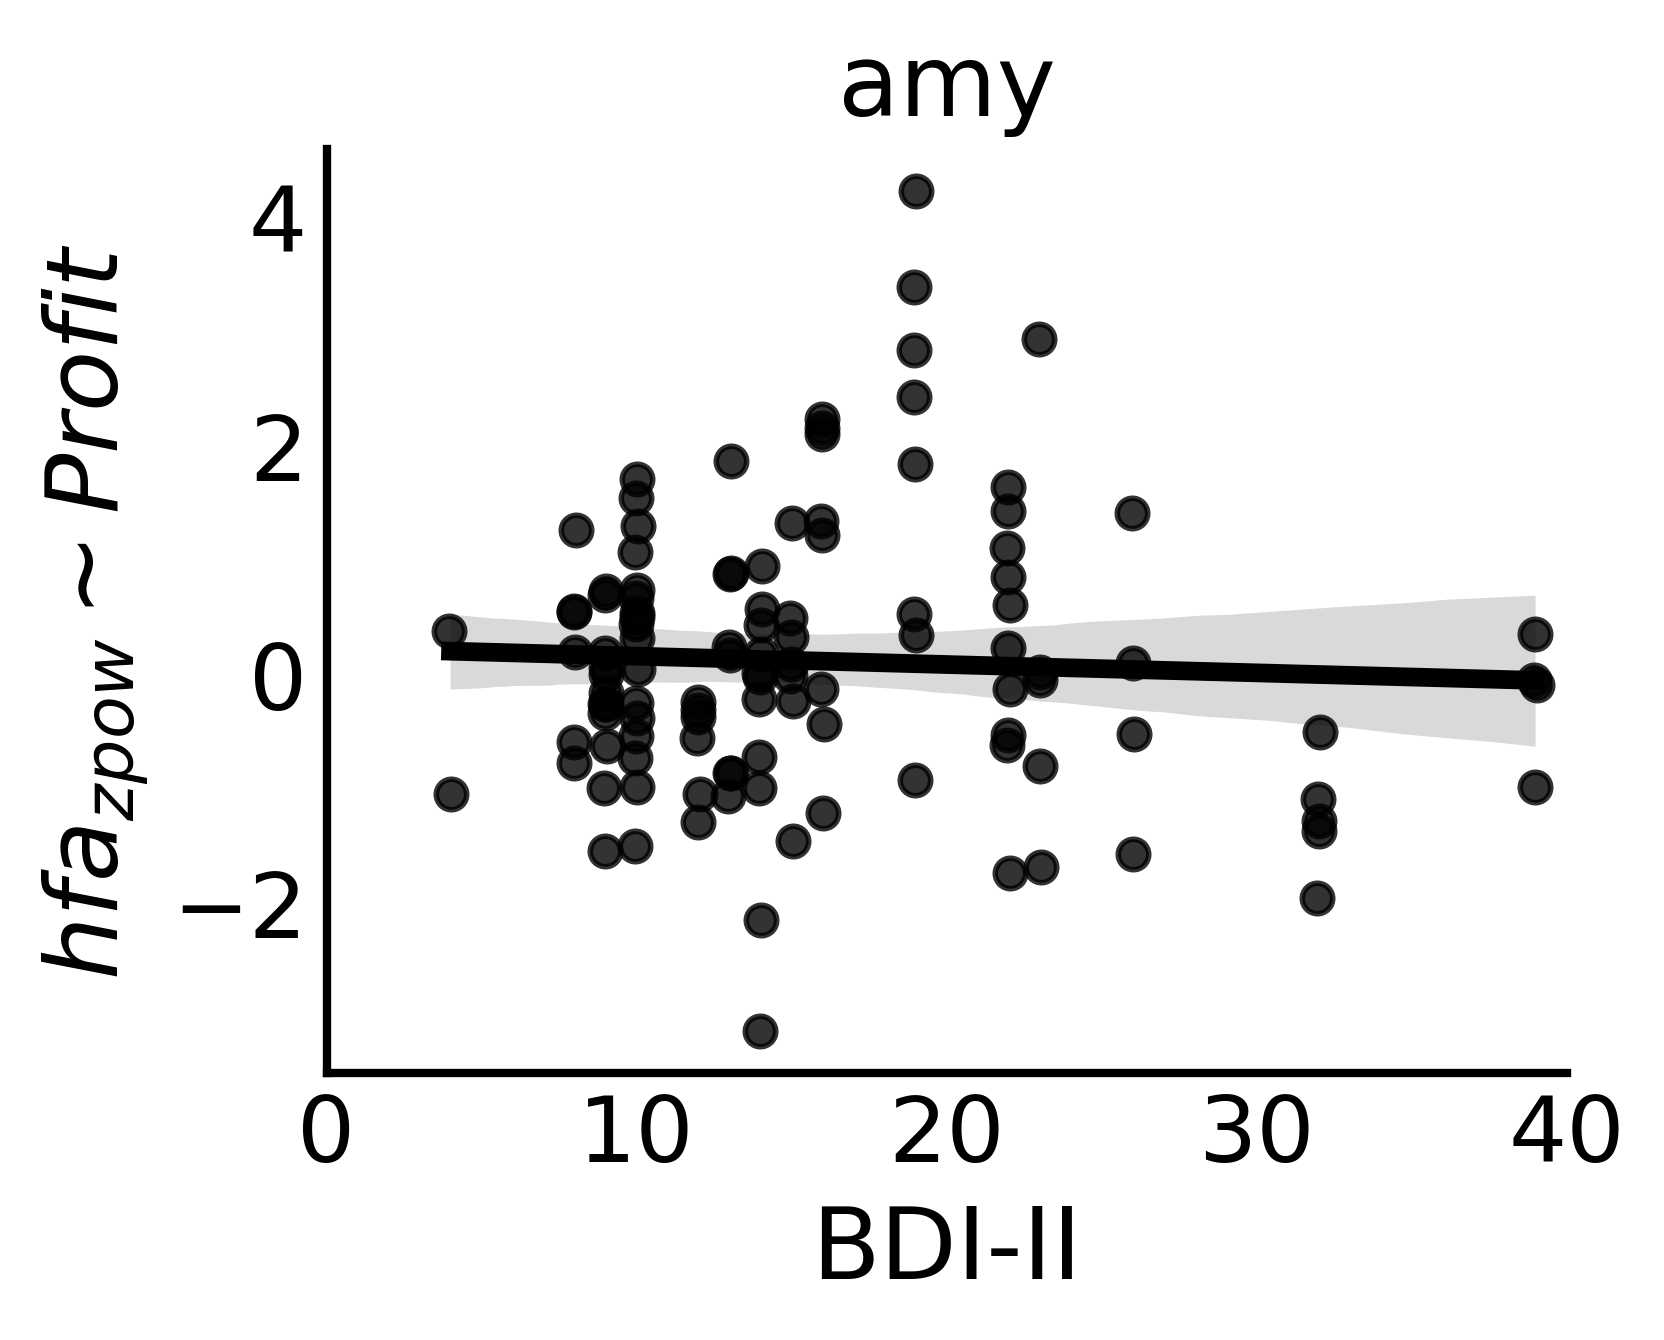

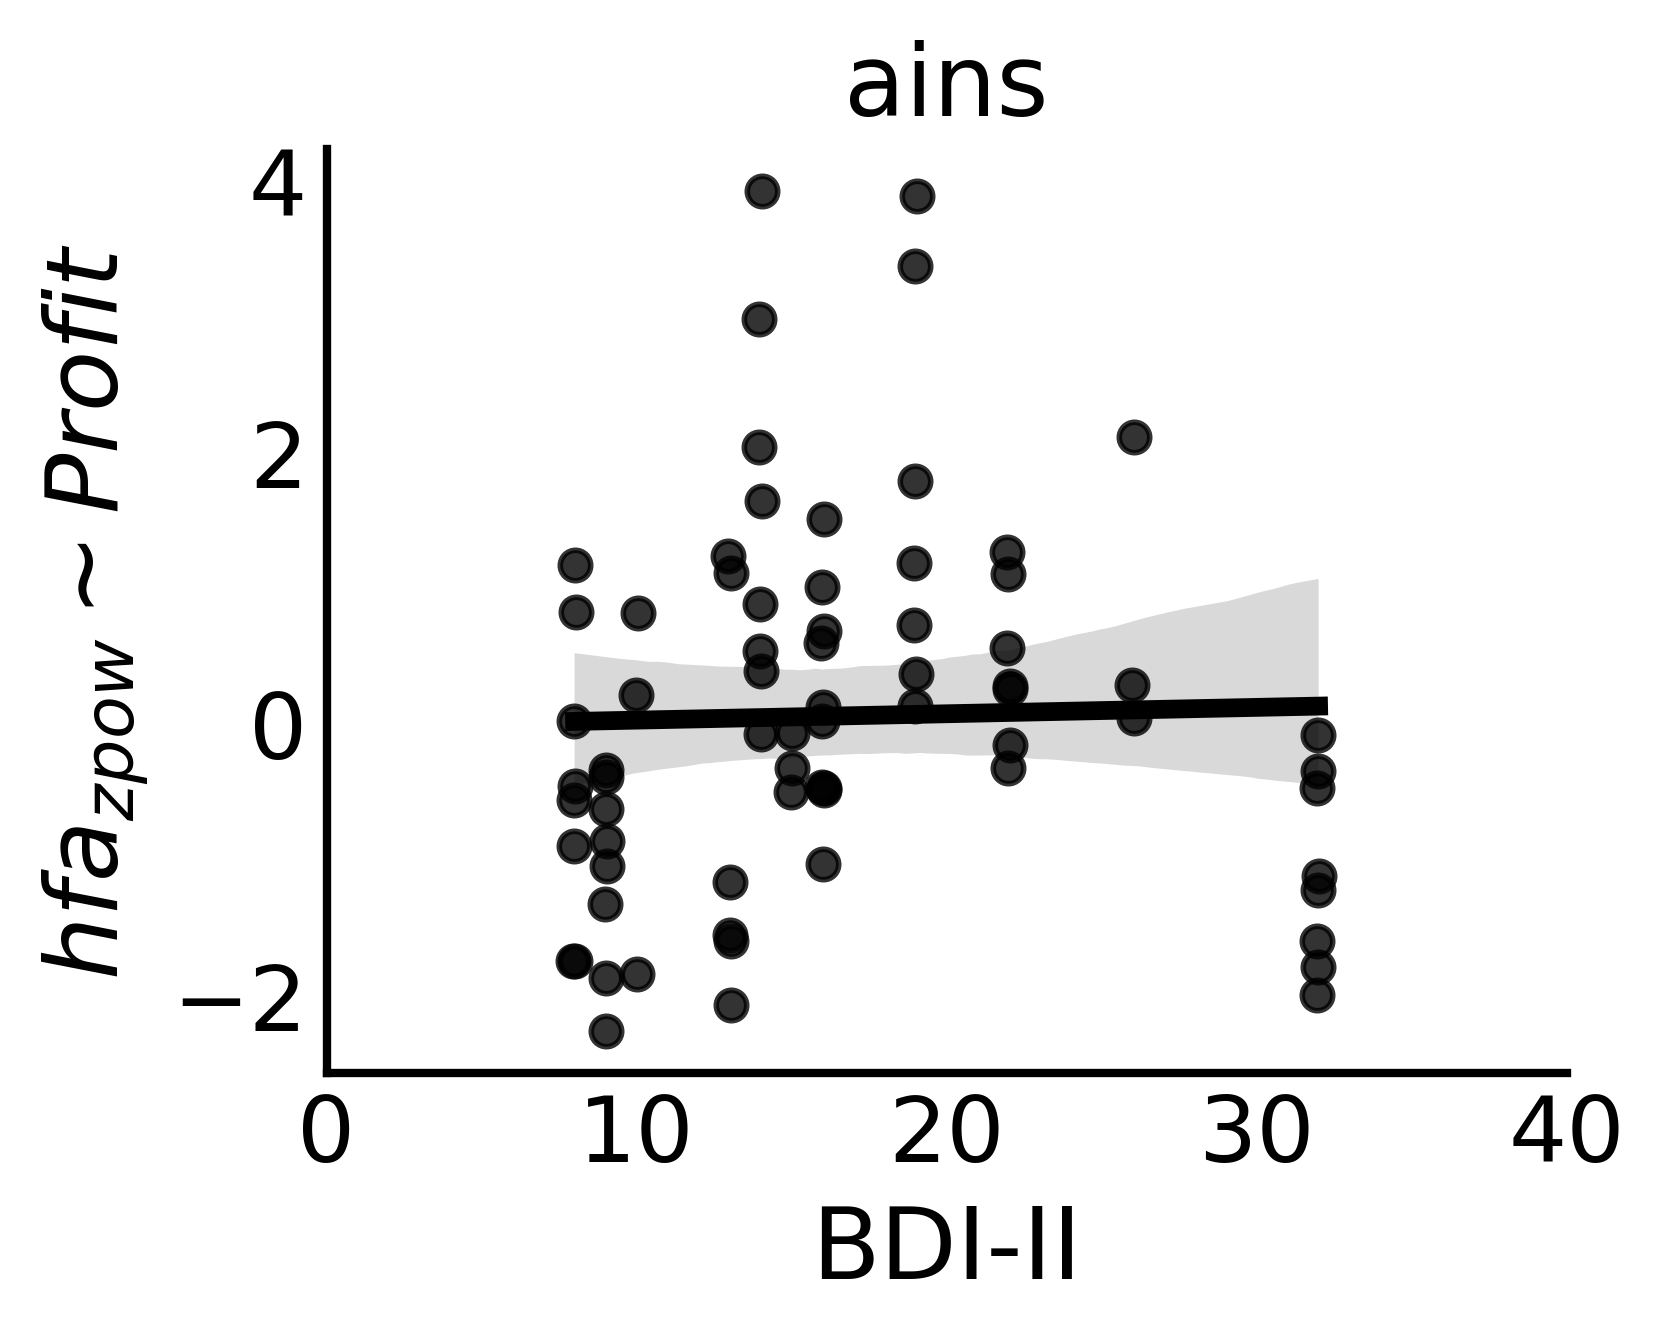

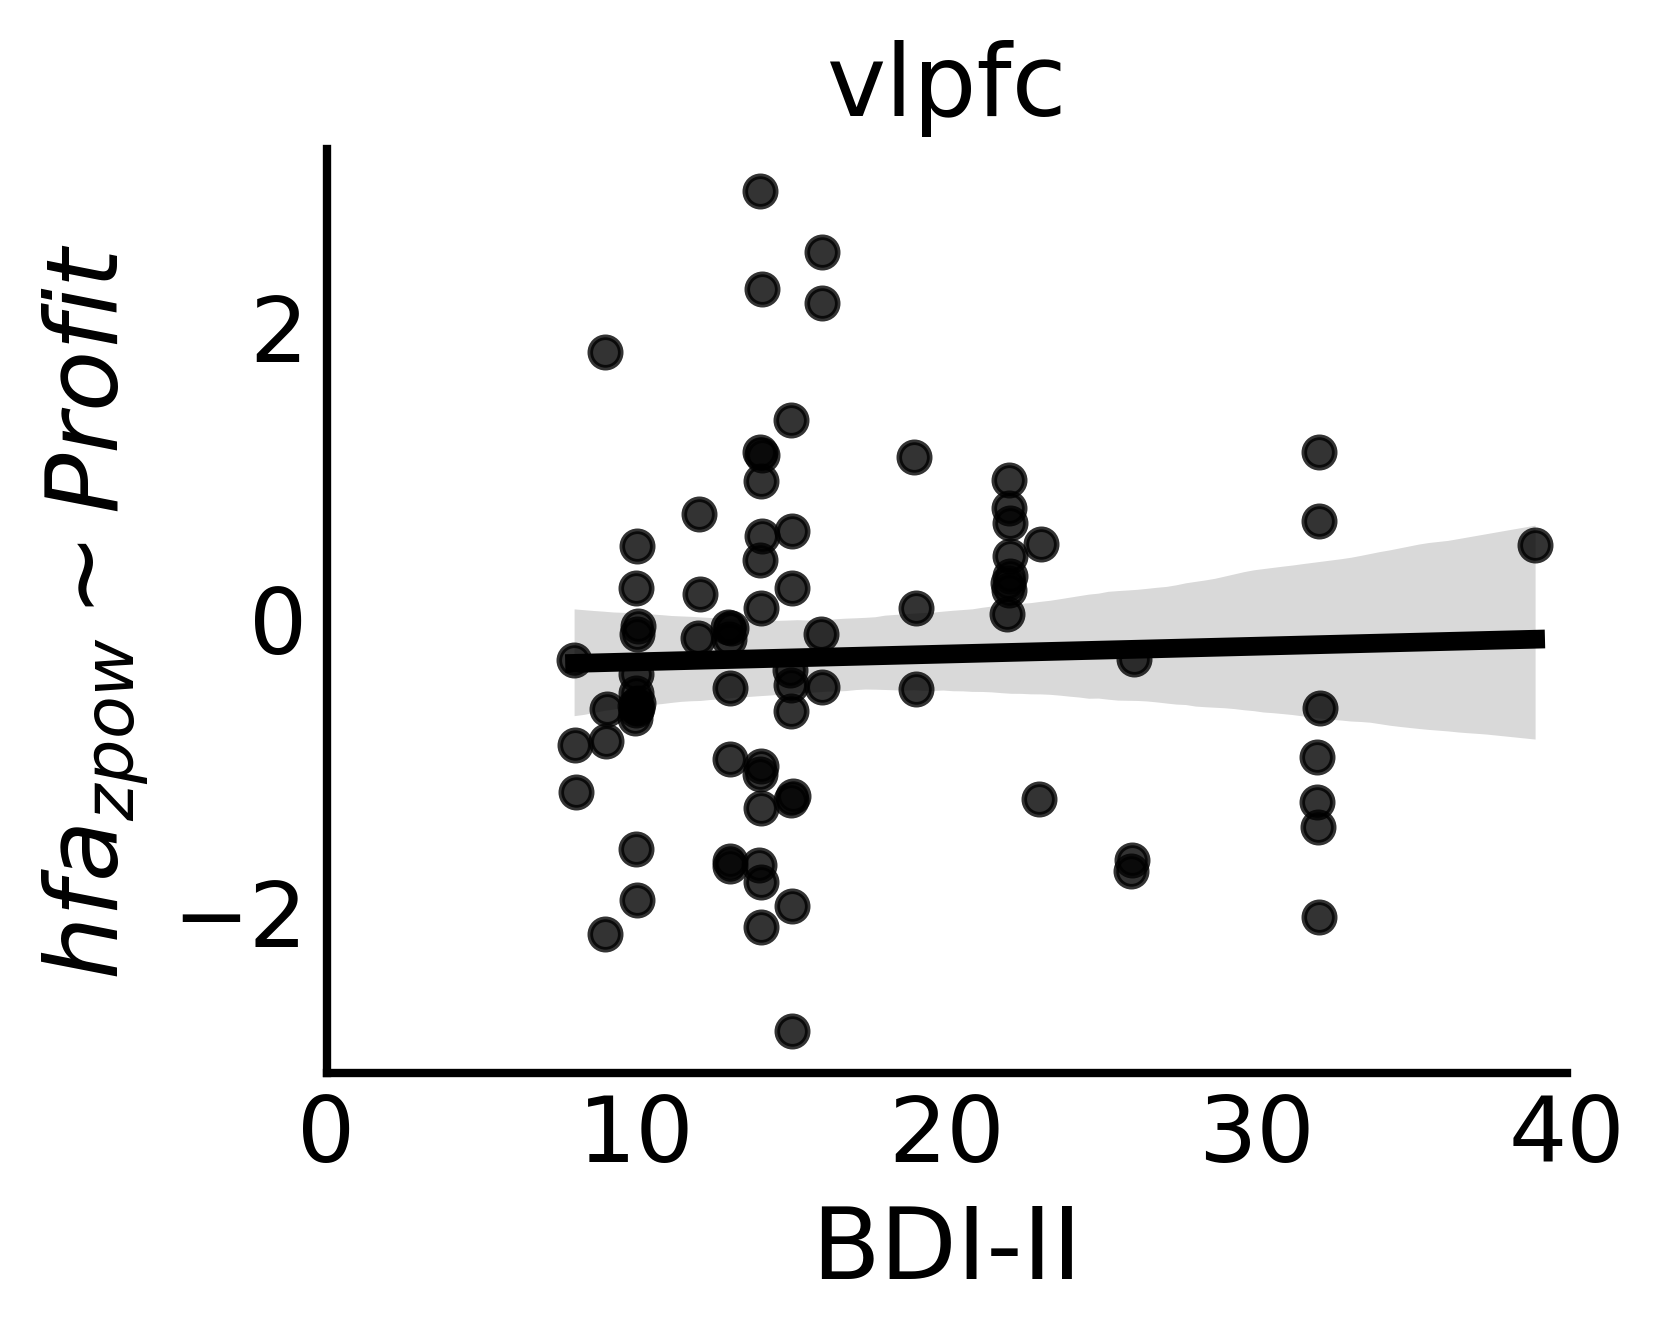

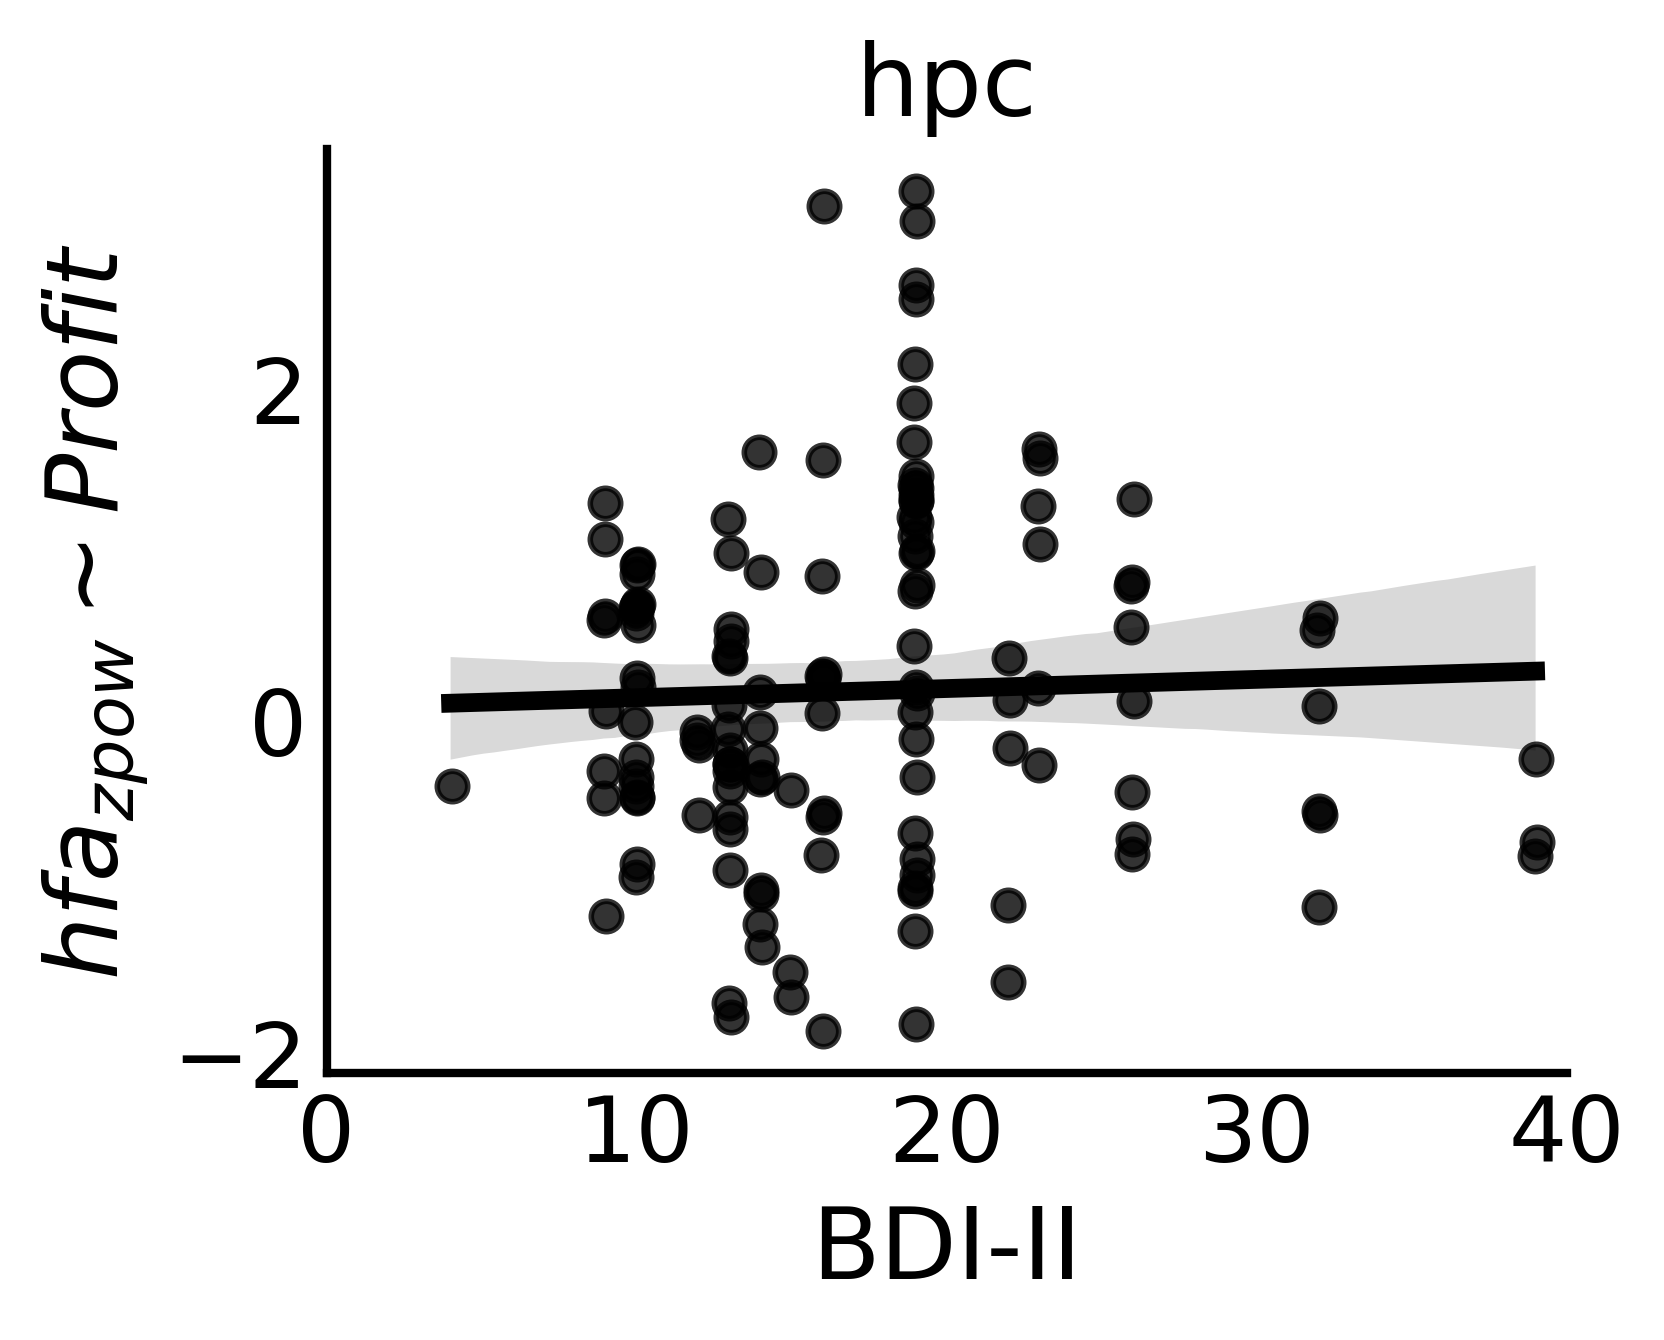

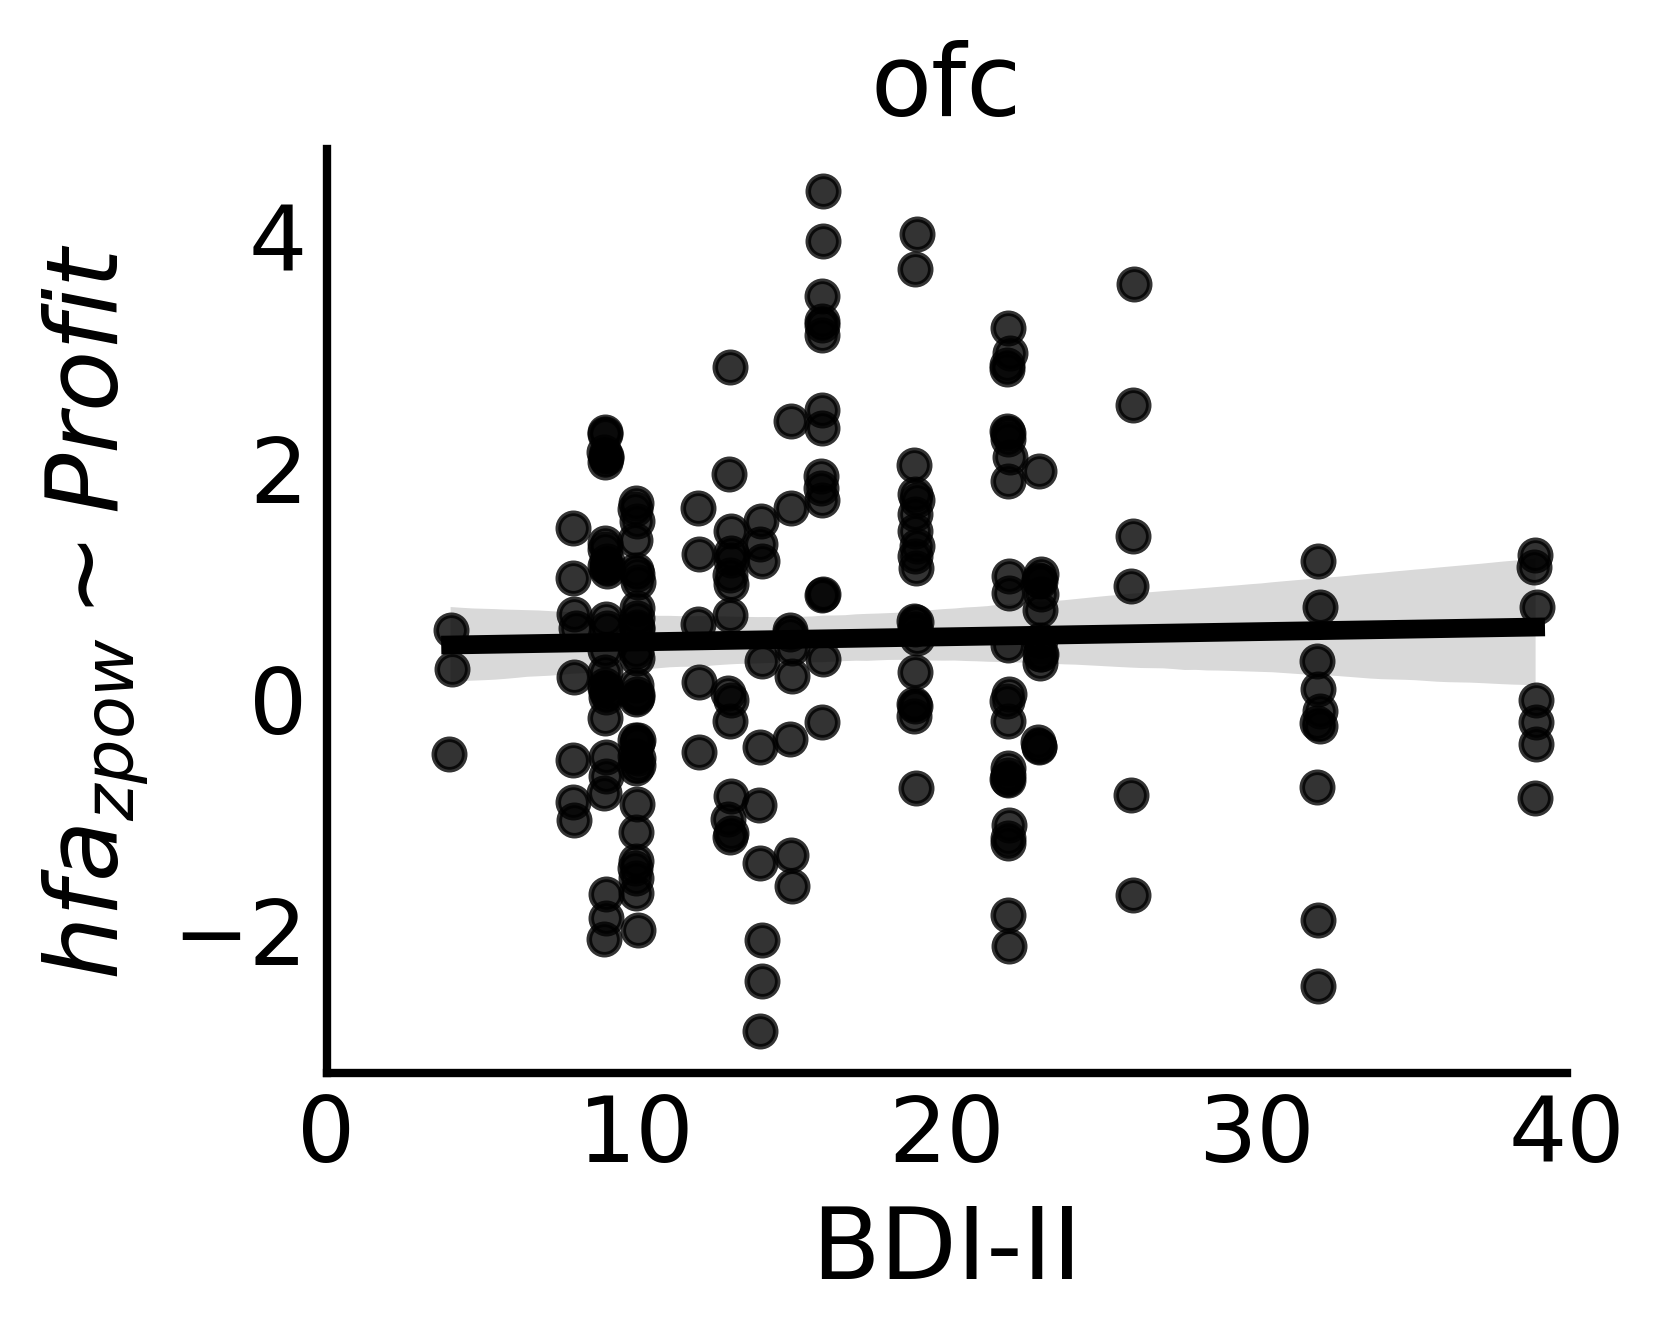

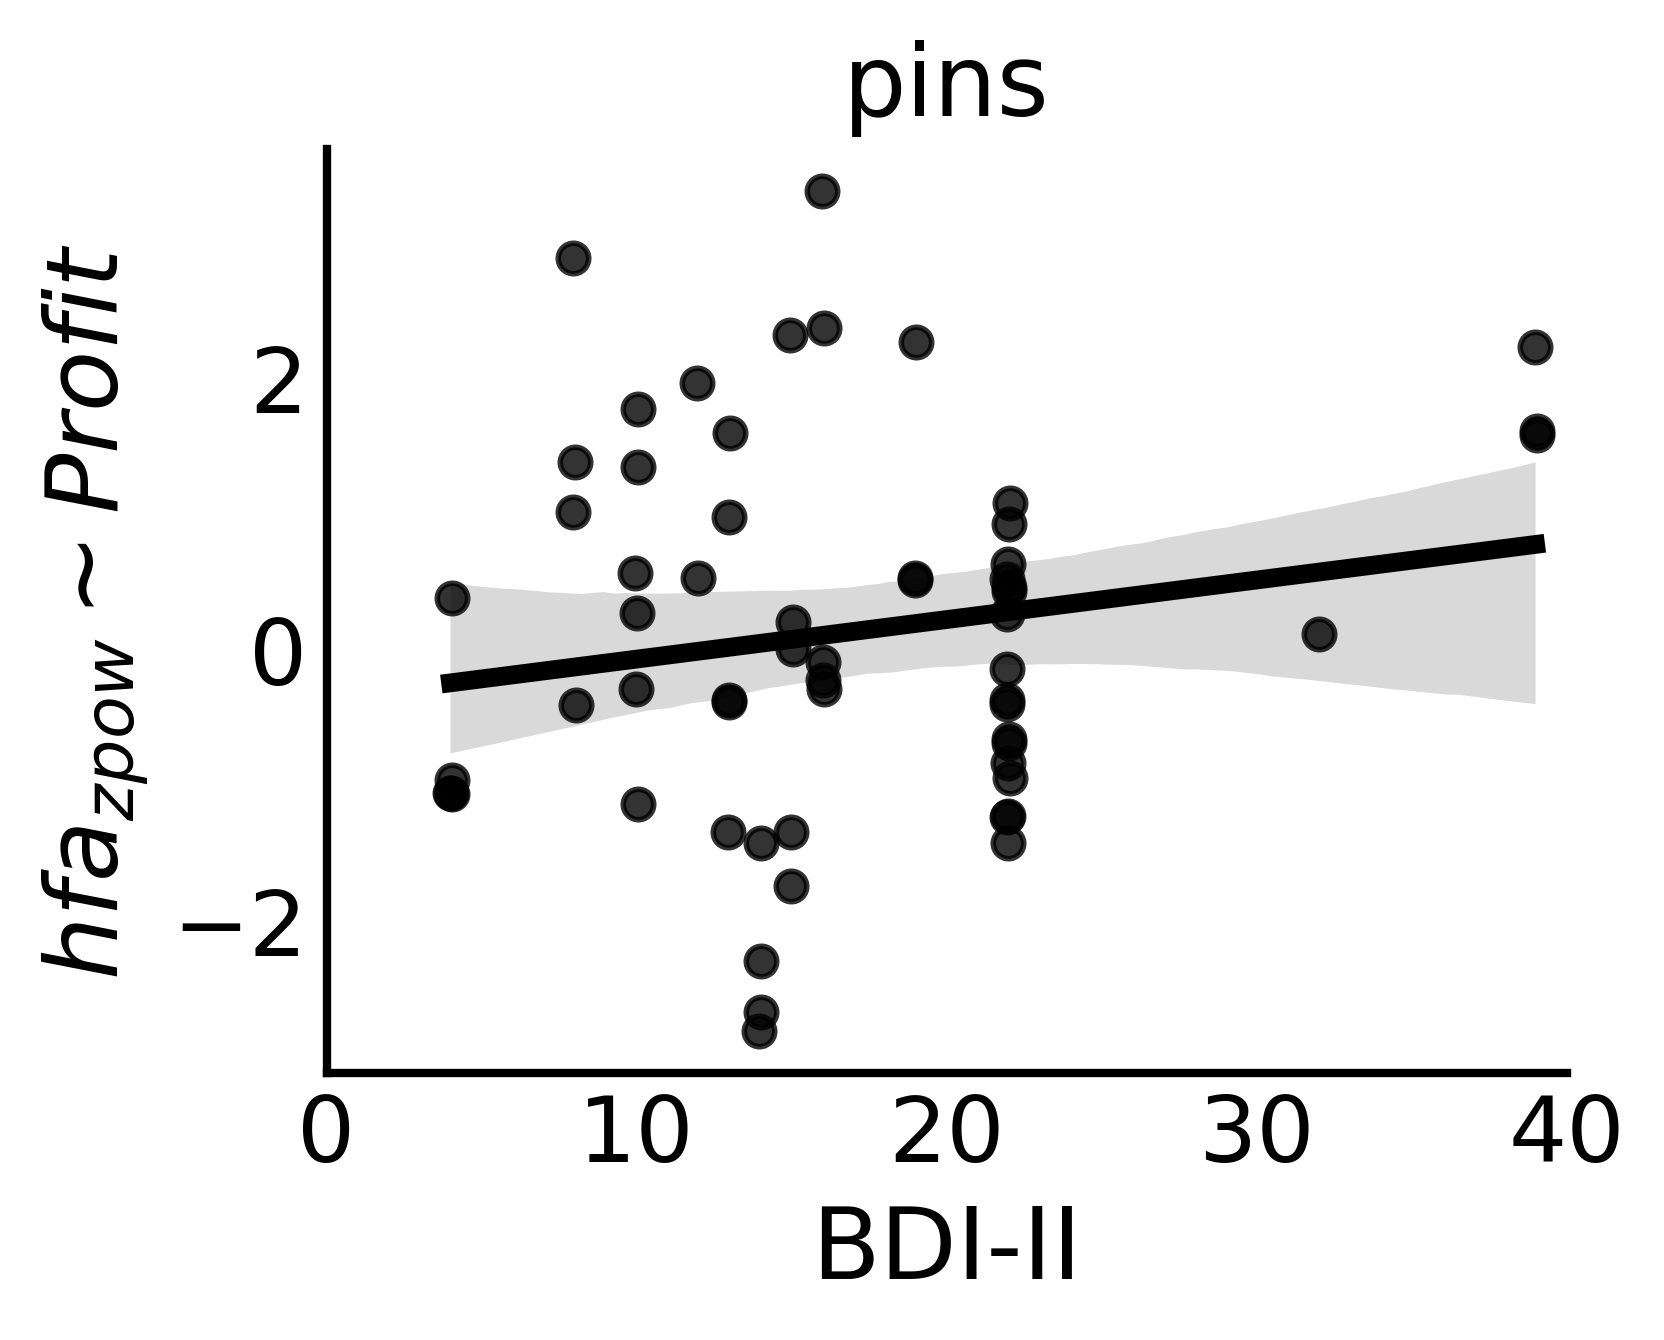

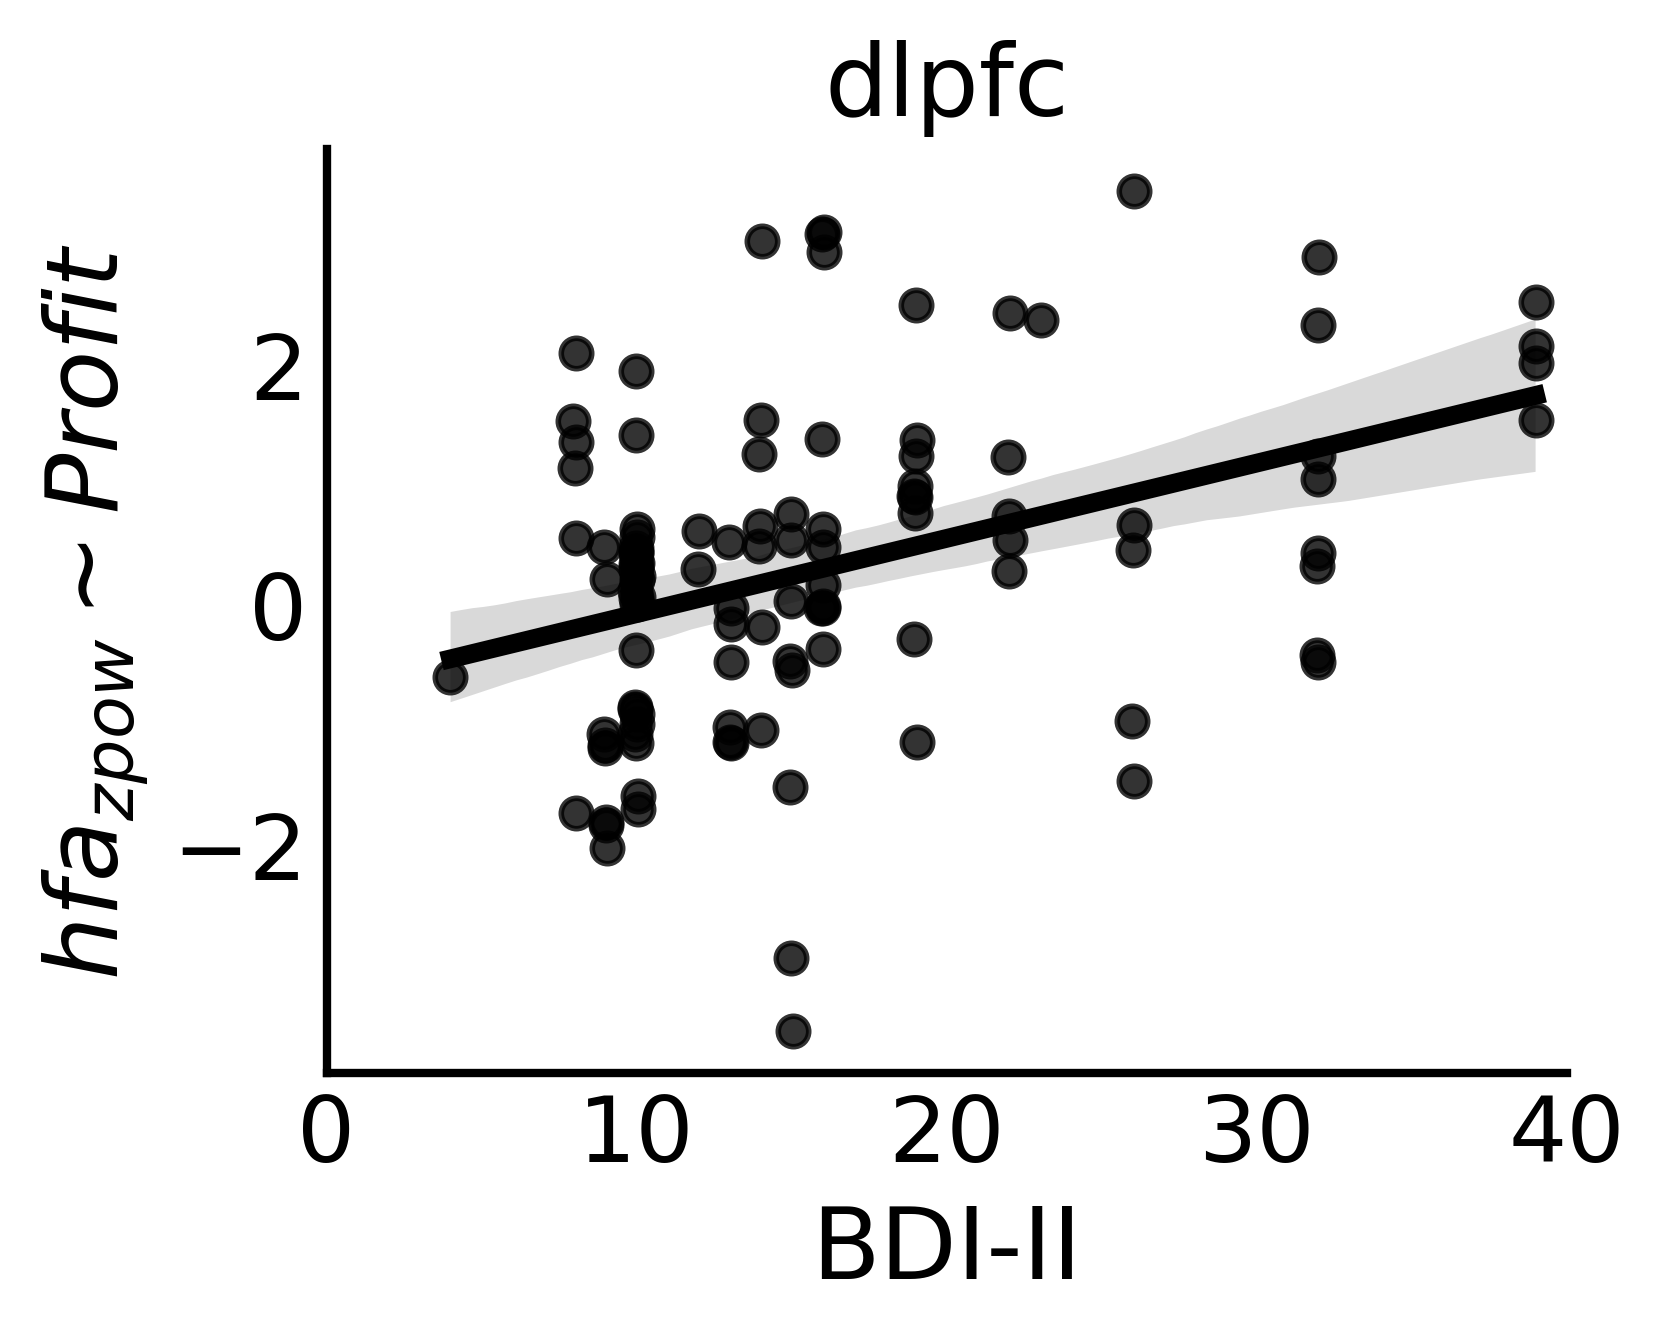

In [43]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_combomodel-Profit-cpe-bdi_Profit_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_Profit',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim Profit$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [44]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_Profit.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        11:37:38                                         
No. Iterations:                    18                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4563      0.463     33.388     